In [1]:
import glob

import numpy as np
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
import random
import pickle
import os
import config
import data
import random
from natsort import natsorted
arm = 'UR5'
PYBULLET_DATA_DIR = config.ONEOBJ_PLAY # config.SCRIPTED_PLAY #config.RPL_PATH
if arm == 'UR5':
    PYBULLET_DATA_DIR = config.UR5
    TEST_DIR = config.UR5_TEST

In [2]:
physical_devices = tf.config.list_physical_devices(config.DEVICE)
if config.DEVICE is 'GPU':
    tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [55]:
# 
RELATIVE = False # use relative joints instead of absolute pos/ori as in the original paper
QUAT =  False # whether to use quaternions or rpy in actions
JOINTS = False # use relative joints instead of absolute angles
VELOCITY = False
USE_QUAT_OBS = False

LAYER_SIZE = 2048
LATENT_DIM = LAYER_SIZE//8
GRIPPER_WEIGHT = 5.0
GCBC = False
PROBABILISTIC = False

arm = 'UR5'



In [7]:
#dataset, cnt = data.create_single_dataset(dataset_path)
def load_data(path, keys):
    dataset = {k:[] for k in keys+['sequence_index','sequence_id']}
    obs_act_path = os.path.join(path, 'obs_act_etc/')

    for demo in natsorted(os.listdir(obs_act_path)):
        print(demo)
        traj = np.load(obs_act_path+demo+'/data.npz')
        for k in keys:
            dataset[k].append(traj[k].astype(np.float32))
        timesteps = len(traj['obs'])
        dataset['sequence_index'].append(np.arange(timesteps, dtype=np.int32).reshape(-1, 1))
        dataset['sequence_id'].append(np.full(timesteps, fill_value=int(demo), dtype=np.int32).reshape(-1, 1))

    # convert to numpy
    for k in keys+['sequence_index','sequence_id']:
        dataset[k] = np.vstack(dataset[k])
    return dataset

In [8]:
keys = ['obs', 'acts', 'achieved_goals', 'joint_poses', 'target_poses', 'acts_rpy', 'acts_rpy_rel',  'velocities', 'obs_rpy']
dataset = load_data(PYBULLET_DATA_DIR, keys)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


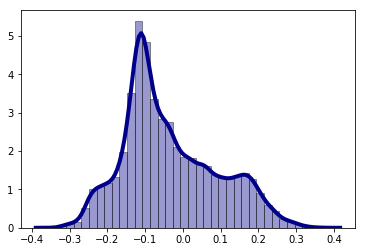

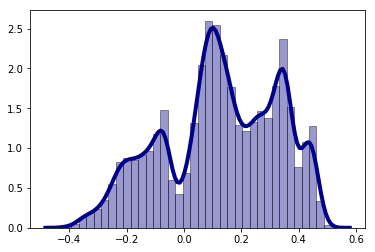

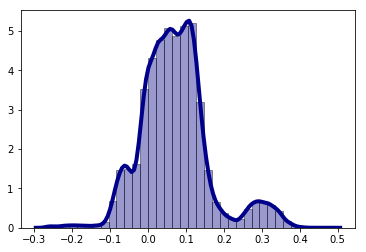

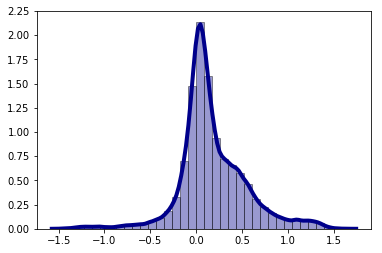

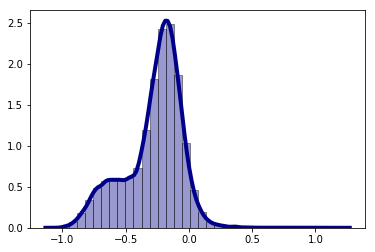

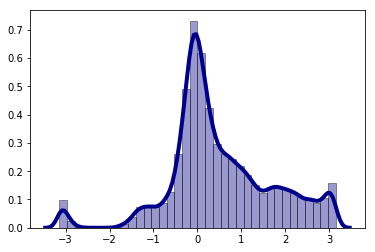

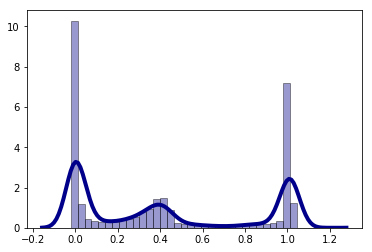

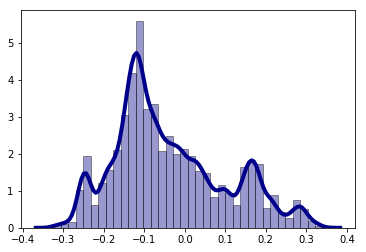

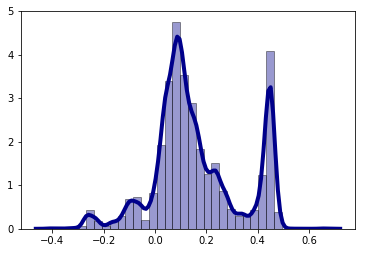

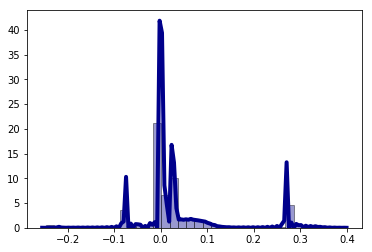

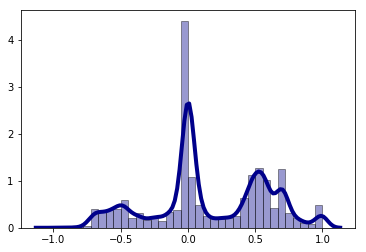

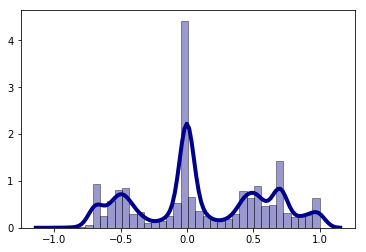

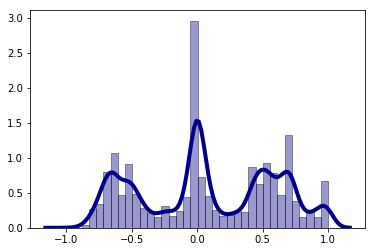

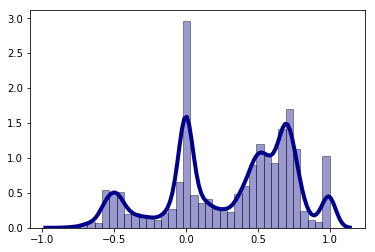

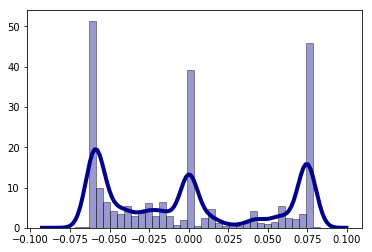

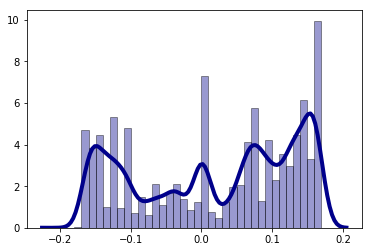

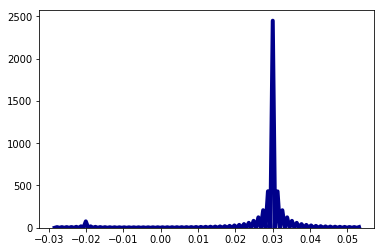

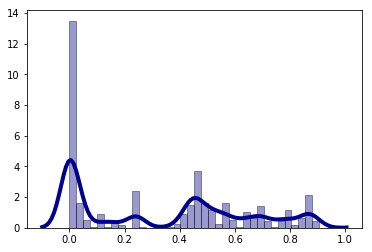

In [9]:
import seaborn as sns
for i in range(0,dataset['obs_rpy'].shape[1]):
    sns.distplot(dataset['obs_rpy'][:,i], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
    plt.show()

In [10]:

if JOINTS:
    OBS_DIM = dataset['obs'].shape[1] + 7 
    ACT_DIM = dataset['target_poses'].shape[1] + 1
else:
    if USE_QUAT_OBS:
      OBS_DIM = dataset['obs'].shape[1]
    else:
      OBS_DIM = dataset[rpy_obs].shape[1]
    
    if QUAT:
        ACT_DIM = dataset['acts'].shape[1]
    else:
        ACT_DIM = dataset['acts_rpy'].shape[1]

if VELOCITY:
    OBS_DIM += dataset['velocities'].shape[1]
        
GOAL_DIM = dataset['achieved_goals'].shape[1]
print(f'Obs: (N,{OBS_DIM}), Acts: (N,{ACT_DIM}), Goals: (N,{GOAL_DIM})')

Obs: (N,18), Acts: (N,7), Goals: (N,11)


In [11]:
DATASET_SIZE = dataset['obs'].shape[0]
secs = DATASET_SIZE / 25
hours = secs // 3600
minutes = secs // 60 - hours * 60
print(f"We have {DATASET_SIZE} frames of data, which is {hours:.0f}hrs {minutes:.0f}m.")

We have 93274 frames of data, which is 1hrs 2m.


In [75]:
import pybullet
BATCH_SIZE_PER_REPLICA = 32
GLOBAL_BATCH_SIZE = BATCH_SIZE_PER_REPLICA

WINDOW_SIZE = 60
MIN_WINDOW_SIZE = 40
WINDOW_SHIFT = 1
SHUFFLE_SIZE = GLOBAL_BATCH_SIZE*100
PREFETCH_SIZE = tf.data.experimental.AUTOTUNE
NUM_WORKERS = 4
TRAIN_TEST_SPLIT = 0.9
VARIABLE_SEQ_LENS = True

window_lambda = lambda x: tf.data.Dataset.zip(x).batch(WINDOW_SIZE)
seq_overlap_filter = lambda x: tf.equal(tf.size(tf.unique(tf.squeeze(x['sequence_id'])).y), 1)

def create_goal_tensor(dataset, seq_len=-1):
    ''' Tile final achieved_goal across time dimension '''
    tile_dims = tf.constant([WINDOW_SIZE, 1], tf.int32)
    goal = tf.tile(dataset['achieved_goals'][seq_len-1,tf.newaxis], tile_dims) # as goal is at an index take seq_len -1
    return goal

def transform_states(dataset):
    if JOINTS:
        if RELATIVE:
          if arm == 'UR5':
              rel = dataset['target_poses'] - dataset['joint_poses'][:,:6] 
          else:
              rel = dataset['target_poses'] - dataset['joint_poses'][:,:7]
        else:
          rel = dataset['target_poses']

        gripper = dataset['acts'][:,-1,tf.newaxis]
        acts = tf.concat([rel, gripper], axis=-1)
        obs = tf.concat([dataset['obs'],dataset['joint_poses'][:,:7]], axis=-1)#.astype('float32')
    else:
        if USE_QUAT_OBS:
          obs = dataset['obs']
        else:
          obs = dataset[rpy_obs]
        
        
        if RELATIVE:
            if QUAT:
                rel = dataset['acts'][:,:7] - dataset['obs'][:,:7]
            else:
                rel = dataset['acts_rpy'][:,:6] - dataset[rpy_obs][:,:6]
                
            gripper = dataset['acts'][:,-1,tf.newaxis]
            acts = tf.concat([rel, gripper], axis=-1)
        else:
            if QUAT:
                acts = dataset['acts']
            else:
                acts = dataset['acts_rpy']

    if VELOCITY:
      obs = tf.concat([obs, dataset['velocities']], axis = -1)
    
    # Variable Seq len
    if VARIABLE_SEQ_LENS:
      seq_len = tf.random.uniform(shape=[], minval=MIN_WINDOW_SIZE, maxval=WINDOW_SIZE, dtype=tf.int32, seed=10)
    else:
      seq_len = WINDOW_SIZE # SEQLENS Just at max window size

    print(obs.shape)
    mask = tf.cast(tf.sequence_mask(seq_len, maxlen=WINDOW_SIZE), tf.float32) # creates a B*T mask
    multiply_mask = tf.expand_dims(mask, -1)

    goals = create_goal_tensor(dataset, seq_len)

    obs = obs * multiply_mask
    acts = acts * multiply_mask
    goals = goals * multiply_mask
    
    ags = dataset['achieved_goals'] * multiply_mask
    ag_to_goal = abs(ags - goals)
    print(multiply_mask)
    r = (1.0-tf.cast((tf.reduce_mean(tf.cast(ag_to_goal > 0.05, tf.float32), -1) > 0), tf.float32)) * tf.squeeze(multiply_mask)
    
    

    

    return {'obs':obs, 'acts':acts, 'goals':goals, 'seq_lens': tf.cast(seq_len, tf.float32), 'masks':mask, 
           'dataset_path':dataset['sequence_id'], 'tstep_idxs':dataset['sequence_index'], 'ags': ags ,
            'reward': ag_to_goal, 'reward': r}

def tf_ds_transform(dataset):
    return dataset\
                .window(size=WINDOW_SIZE, shift=WINDOW_SHIFT, stride=1, drop_remainder=True)\
                .flat_map(window_lambda)\
                .filter(seq_overlap_filter)\
                .shuffle(SHUFFLE_SIZE)\
                .repeat()\
                .map(transform_states, num_parallel_calls=NUM_WORKERS)\
                .batch(GLOBAL_BATCH_SIZE, drop_remainder=True)\
                .prefetch(PREFETCH_SIZE)\
                # .cache()

# Todo: Need to confirm splitting here works with shuffle() and repeat()
train_size = int(TRAIN_TEST_SPLIT * DATASET_SIZE)

full_dataset = tf.data.Dataset.from_tensor_slices(dataset)
train_dataset = tf_ds_transform(full_dataset.take(len(full_dataset)))

valid_dataset = load_data(TEST_DIR, keys)
valid_dataset = tf.data.Dataset.from_tensor_slices(valid_dataset)
valid_dataset = tf_ds_transform(valid_dataset.take(len(valid_dataset)))
train_dataset

(None, 18)
Tensor("ExpandDims:0", shape=(60, 1), dtype=float32)
0
1
(None, 18)
Tensor("ExpandDims:0", shape=(60, 1), dtype=float32)


<PrefetchDataset shapes: {obs: (32, 60, 18), acts: (32, 60, 7), goals: (32, 60, 11), seq_lens: (32,), masks: (32, 60), dataset_path: (32, None, 1), tstep_idxs: (32, None, 1), ags: (32, 60, 11), reward: (32, 60)}, types: {obs: tf.float32, acts: tf.float32, goals: tf.float32, seq_lens: tf.float32, masks: tf.float32, dataset_path: tf.int32, tstep_idxs: tf.int32, ags: tf.float32, reward: tf.float32}>

In [19]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, ReLU, Input, LSTM, Concatenate, Masking, Reshape, Lambda
from tensorflow.keras.regularizers import l1, l2
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpl = tfp.layers

In [20]:
from custom_layers import LearnedInitLSTM

In [21]:

def latent_normal(inputs):
    mu, scale = inputs
    dist = tfd.Normal(loc=mu, scale=scale)
    return dist


def logistic_mixture(inputs):
    weightings, mu, scale = inputs
    dist = tfd.Logistic(loc=mu, scale=scale)
    mixture_dist = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(logits=weightings),
        components_distribution=dist,
        validate_args=True
    )
    return mixture_dist

def create_actor(layer_size=1024, latent_dim = 256, epsilon=1e-4, num_distribs=None, GCBC=False, training=True, return_state=False):
    # params #
    batch_size = None if training else 1
    stateful = not training

    # Input #
    o = Input(shape=(None, OBS_DIM), batch_size=batch_size, dtype=tf.float32, name='input_obs')
    z = Input(shape=(None, latent_dim), batch_size=batch_size, dtype=tf.float32, name='input_latent')
    g = Input(shape=(None, GOAL_DIM), batch_size=batch_size, dtype=tf.float32, name='input_goals')

    # RNN #
    if GCBC:      
      x =  Concatenate(axis=-1)([o,g])
    else:
      x =  Concatenate(axis=-1)([o,z,g])

    x = Masking(mask_value=0.)(x)
    if return_state:
#         x, _, state1 = LearnedInitLSTM(layer_size, return_sequences=True, stateful=stateful, name='LSTM_in_1', return_state=return_state)(x)
#         x, _, state2= LearnedInitLSTM(layer_size, return_sequences=True, stateful=stateful, name='LSTM_in_2', return_state=return_state)(x)
        x, _, state1 = LSTM(layer_size, return_sequences=True, stateful=stateful, name='LSTM_in_1', return_state=return_state)(x)
        x, _, state2= LSTM(layer_size, return_sequences=True, stateful=stateful, name='LSTM_in_2', return_state=return_state)(x)
    else:
#         x = LearnedInitLSTM(layer_size, return_sequences=True, stateful=stateful, name='LSTM_in_1', return_state=return_state)(x)
#         x = LearnedInitLSTM(layer_size, return_sequences=True, stateful=stateful, name='LSTM_in_2', return_state=return_state)(x)
        x = LSTM(layer_size, return_sequences=True, stateful=stateful, name='LSTM_in_1', return_state=return_state)(x)
        x = LSTM(layer_size, return_sequences=True, stateful=stateful, name='LSTM_in_2', return_state=return_state)(x)
    # Probabilistic Mixture Model #
    if num_distribs:
        weightings = Dense(ACT_DIM*num_distribs, activation=None, name='alpha')(x)
        mu = Dense(ACT_DIM*num_distribs, activation=None, name='mu')(x)
        scale = Dense(ACT_DIM*num_distribs, activation="softplus", name='sigma')(x + epsilon)

        weightings = Reshape((-1, ACT_DIM, num_distribs))(weightings)
        mu = Reshape((-1, ACT_DIM, num_distribs))(mu)
        scale = Reshape((-1, ACT_DIM, num_distribs))(scale)
        
        actions = tfpl.DistributionLambda(logistic_mixture, name='logistic_mix')([weightings, mu, scale])
    else:
        actions = Dense(ACT_DIM, activation=None, name='acts')(x)
    
    if return_state:
        if GCBC:
          return Model([o, g], [actions, state1, state2])
        else:
          return Model([o, z, g], [actions, state1, state2])
    else:
        if GCBC:
          return Model([o, g], actions)
        else:
          return Model([o, z, g], actions)


In [22]:
from tensorflow.keras.layers import Bidirectional


def create_encoder(layer_size=2048, latent_dim = 256, epsilon=1e-4, training=True):
    # Input #
    obs = Input(shape=(WINDOW_SIZE, OBS_DIM), dtype=tf.float32, name='obs')
    acts = Input(shape=(WINDOW_SIZE, ACT_DIM), dtype=tf.float32, name='acts') 

    # Layers #
    x = Concatenate(axis=-1)([obs, acts])
    x = Masking(mask_value=0.)(x)
    x = Bidirectional(LSTM(layer_size//4, return_sequences=True), merge_mode='concat')(x)
    x = Bidirectional(LSTM(layer_size//4, return_sequences=False), merge_mode='concat')(x)

    # Latent Variable # 
    mu = Dense(latent_dim, activation=None, name='mu')(x)
    scale = Dense(latent_dim, activation="softplus", name='sigma')(x + epsilon)
    
    mixture = tfpl.DistributionLambda(latent_normal, name='latent_variable')((mu, scale))
    return Model([obs, acts], mixture)


def create_planner(layer_size=2048, latent_dim = 256, epsilon=1e-4, training=True):
    # params #
    batch_size = None

    # Input #
    o_i = Input(shape=(OBS_DIM,), batch_size=batch_size, dtype=tf.float32, name='initial_obs') # has arm state
    o_g = Input(shape=(GOAL_DIM,), batch_size=batch_size, dtype=tf.float32, name='goal_obs') # does not have arm state

    # Layers #
    x = Concatenate(axis=-1)([o_i, o_g])
    x = Masking(mask_value=0.)(x)
    x = Dense(layer_size//4, activation="relu", name='layer_1')(x)
    x = Dense(layer_size//4, activation="relu", name='layer_2')(x)
    x = Dense(layer_size//4, activation="relu", name='layer_3')(x)
    x = Dense(layer_size//4, activation="relu", name='layer_4')(x)

    # Latent Variable # 
    mu = Dense(latent_dim, activation=None, name='mu')(x)
    scale = Dense(latent_dim, activation="softplus", name='sigma')(x + epsilon)
    
    mixture = tfpl.DistributionLambda(latent_normal,  name='latent_variable')((mu, scale))
    return Model([o_i, o_g], mixture)




# Load our beautiful models

In [17]:



# model_params = {'layer_size':LAYER_SIZE, 'latent_dim':LATENT_DIM, 'training':True}
# model = create_actor(**model_params)

model_params = {'layer_size':LAYER_SIZE, 'latent_dim':LATENT_DIM}
if PROBABILISTIC:
    actor = create_actor(**model_params, GCBC
                         =GCBC, num_distribs=3)
else:
    actor = create_actor(**model_params, GCBC=GCBC)
    
if not GCBC:
    encoder = create_encoder(**model_params)
    planner = create_planner(**model_params)

In [15]:
actor.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_obs (InputLayer)          [(None, None, 18)]   0                                            
__________________________________________________________________________________________________
input_latent (InputLayer)       [(None, None, 256)]  0                                            
__________________________________________________________________________________________________
input_goals (InputLayer)        [(None, None, 11)]   0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, None, 285)    0           input_obs[0][0]                  
                                                                 input_latent[0][0]    

In [16]:
path = 'B0.001' #ABS_RPY_GCBC_UR5 #ABS_RPY_GCBC_2hrs
#path = ''REL_RPY_GCBC_UR5v2' 
model_index = ""
if GCBC:
    actor.load_weights(f'saved_models/{path}/model'+model_index+'.h5')
else:
    encoder.load_weights(f'saved_models/{path}/encoder'+model_index+'.h5')
    planner.load_weights(f'saved_models/{path}/planner'+model_index+'.h5')

In [17]:
# hyper_params = np.load(f'saved_models/{path}/hyper_params.npz', allow_pickle=True)
# for x in hyper_params.items():
#     print(x)

FileNotFoundError: [Errno 2] No such file or directory: 'saved_models/B0.001/hyper_params.npz'

In [23]:
v_it = iter(valid_dataset)
batch = v_it.next()
states,acts,goals,seq_lens,masks = batch['obs'],batch['acts'],batch['goals'],batch['seq_lens'],batch['masks']
if GCBC:
  pred_acts = actor([states, goals])
else:
  encoding = encoder([states,acts])
  plan = planner([states[:, 0, :], goals[:, 0, :]]) 
                                                  
  # check if encoder is overfitting on validation
  z_enc = z = tf.tile(tf.expand_dims(encoding.sample(), 1), (1, WINDOW_SIZE, 1))
  enc_act_distrib = actor([states, z_enc, goals])

  # true validation performance, w/ planner
  z = tf.tile(tf.expand_dims(plan.sample(), 1), (1, WINDOW_SIZE, 1))
  pred_acts = actor([states, z, goals]) 

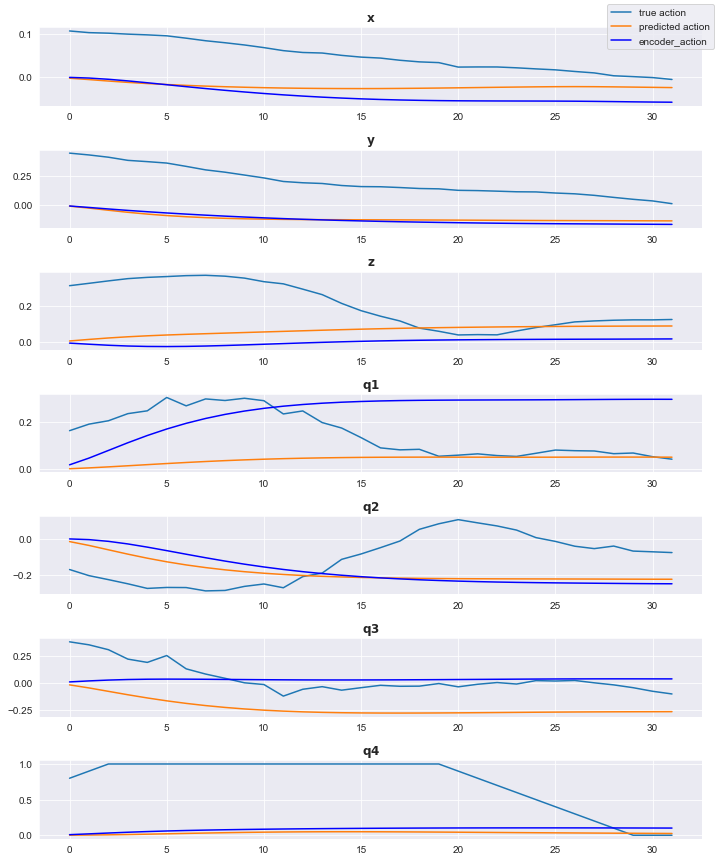

In [24]:
#@title Plot timeseries of state/action tracking over time - xyz q1234 gripper
import seaborn as sns
sns.set_style("darkgrid")

idx = 7
seq_len = int(seq_lens[idx])
x = np.arange(seq_len)
labels = ['x','y','z','q1','q2','q3','q4','gripper']
fig, axes = plt.subplots(ACT_DIM, 1, figsize=(10,12), squeeze=True)
for i in range(ACT_DIM):
    #sns.lineplot(x, acts[idx,:seq_len,i], color='r', ax=axes[i])
    axes[i].plot(acts[idx,:seq_len,i])
    axes[i].plot(pred_acts[idx, :seq_len,i])
    #sns.lineplot(x, pred_acts[idx, :seq_len,i], color='g', ax=axes[i])
    if not GCBC:
      sns.lineplot(x, enc_act_distrib[idx, :seq_len,i], color='b', ax=axes[i])
      axes[i].set_title(f'$\\bf{labels[i]}$')
    
fig.legend( ('true action', 'predicted action', 'encoder_action'))    
plt.tight_layout()
plt.show()

In [25]:
colors_dict = {
 'press button': [1,0,0], # red
 'dial off': [0.2, 0.6, 0.2], # green
 'dial on': [0, 0.8, 0], # bolder green
 'door left':[0.6, 0, 0.8], # purple #9900cc
 'door right':[0.8,0.2,0.99],
 'drawer in':[0.4, 0.2,0], # browns #cc9900
 'drawer out':[0.8, 0.6, 0],
 'block in drawer':[1,1,0.4], # yellows
 'block out of drawer':[1,0.8,0.8],
 'block in cupboard left':[1,0.4,1], #brighter purple #ff66ff
 'block in cupboard right':[0.8, 0.4, 1.0], # lighter purpple #cc33ff,,
 'block out of cupboard left':[0.6, 0.4, 1.0], # bluer purpe #9966ff
 'block out of cupboard right':[0.6, 0.6, 1.0], # bluer lilac #9999ff
 'pick place': [0, 0.7, 1.0], # #00BFFF eveertything from here down is shades of blue
 'knock down block': [0.1, 0.6, 0.8],
 'stand up block': [0.05, 0.4, 0.8], ##0E61D1
 'lift up': [0.05, 0.2, 0.7], # #1432BA
 'take down':[0.03, 0.001, 0.6], # #1B03A3
 'rotate block left': [0.2, 0.8, 0.8],
 'rotate block right':[0.2, 0.8, 1.0] 
}

def get_labelled_trajs():
    test_labels = np.load(TEST_DIR + 'trajectory_labels.npz', allow_pickle=True)['trajectory_labels']
    acts,obs,labels, colors = [], [], [], []

    for k,v in test_labels.flatten()[0].items():
        folder = k.split('states_and_ims/')[1].split('/')[0]
        start = int(k.split('env_states/')[1].split('/')[0].strip('.bullet'))
        data = np.load(TEST_DIR+'obs_act_etc/'+folder+'/data.npz')
        traj_len = 40
        end = start + traj_len #min(len(data['acts_rpy'])-1,start+traj_len )
        traj_acts = data['acts_rpy'][start:end]
        traj_obs = data['obs_rpy'][start:end]
        obs.append(traj_obs),acts.append(traj_acts),labels.append(v), colors.append(colors_dict[v])

    return np.array(acts), np.array(obs), labels, colors


import umap
reducer = umap.UMAP(metric='cosine', random_state=42)

def project_labelled_latents(reducer, z_enc):
    ''' Todo: may need to rethink vector averaging here... '''
    reducer.fit(z_enc)
    z_enc_embed = reducer.transform(z_enc)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(z_enc_embed[:, 0], z_enc_embed[:, 1], s=7, label='z_enc', c = colors)
    ax.set_aspect('equal', 'datalim')
    ax.legend(loc='upper left')
    plt.axis('off')
    plt.tight_layout()
    return fig\

obs, acts, labels, colors = get_labelled_trajs()
z = encoder((obs,acts))
o = project_labelled_latents(reducer, z.sample())

FileNotFoundError: [Errno 2] No such file or directory: 'data_collection/collected_data/UR5_25HzNG_test/trajectory_labels.npz'

In [ ]:
env.panda.close()

In [26]:
# string constructors



In [27]:
import gym
import time
import seaborn as sns
import pandaRL
if arm == 'UR5':
    if JOINTS and RELATIVE:
        env = gym.make('UR5PlayRelJoints1Obj-v0')
    elif JOINTS and not RELATIVE:
        env = gym.make('UR5PlayAbsJoints1Obj-v0')
        #env = gym.make('pandaPlayJoints-v0')
    elif not JOINTS and RELATIVE and QUAT:
        env = gym.make('UR5PlayRel1Obj-v0')
    elif not JOINTS and RELATIVE and not QUAT:
        env = gym.make('UR5PlayRelRPY1Obj-v0')
    elif not JOINTS and not RELATIVE and not QUAT:
        env = gym.make('UR5PlayAbsRPY1Obj-v0')
    else:
        env = gym.make('UR5Play1Obj-v0')
else:
    if JOINTS and RELATIVE:
        env = gym.make('pandaPlayRelJoints1Obj-v0')
    elif JOINTS and not RELATIVE:
        env = gym.make('pandaPlayAbsJoints1Obj-v0')
        #env = gym.make('pandaPlayJoints-v0')
    elif not JOINTS and RELATIVE and QUAT:
        env = gym.make('pandaPlayRel1Obj-v0')
    elif not JOINTS and RELATIVE and not QUAT:
        env = gym.make('pandaPlayRelRPY1Obj-v0')
    elif not JOINTS and not RELATIVE and not QUAT:
        env = gym.make('pandaPlayAbsRPY1Obj-v0')
    else:
        env = gym.make('pandaPlay1Obj-v0')
        
env.render('human')
env.reset()

current_dir=c:\users\sholt\desktop\pandarl\pandaRL\envs
current_dir=c:\users\sholt\desktop\pandarl\pandaRL\envs


C:\Users\sholt\Anaconda3\lib\site-packages\gym\logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
C:\Users\sholt\Anaconda3\lib\site-packages\gym\logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
C:\Users\sholt\Anaconda3\lib\site-packages\gym\logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
C:\Users\sholt\Anaconda3\lib\site-packages\gym\logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
C:\Users\sholt\Anaconda3\lib\site-packag

c:\users\sholt\desktop\pandarl\pandaRL\envs


{'observation': array([-7.2600462e-02,  2.5984195e-01,  2.3060608e-01,  4.0120189e-03,
         7.2921831e-03, -1.1524707e-04,  9.9996537e-01, -1.3988549e-04,
         1.7921516e-01,  2.3274362e-02,  4.5254678e-03,  3.8902368e-02,
         1.3367512e-17, -1.1624450e-16,  9.9924302e-01, -3.7729018e-17,
         0.0000000e+00,  1.1222222e-02,  0.0000000e+00], dtype=float32),
 'achieved_goal': array([ 1.7921516e-01,  2.3274362e-02,  4.5254678e-03,  3.8902368e-02,
         1.3367512e-17, -1.1624450e-16,  9.9924302e-01, -3.7729018e-17,
         0.0000000e+00,  1.1222222e-02,  0.0000000e+00], dtype=float32),
 'desired_goal': array([0.08218095, 0.155725  , 0.0594808 ], dtype=float32),
 'controllable_achieved_goal': array([-7.2600462e-02,  2.5984195e-01,  2.3060608e-01, -1.3988549e-04],
       dtype=float32),
 'full_positional_state': array([-7.2600462e-02,  2.5984195e-01,  2.3060608e-01,  4.0120189e-03,
         7.2921831e-03, -1.1524707e-04,  9.9996537e-01, -1.3988549e-04,
         1.7921516

In [28]:
model_params = {'layer_size':LAYER_SIZE, 'latent_dim':LATENT_DIM, 'training':False, 'return_state':True}
if PROBABILISTIC:
    actor = create_actor(**model_params, GCBC=GCBC, num_distribs=3)
else:
    actor = create_actor(**model_params, GCBC=GCBC)


In [86]:
path = 'ABS_RPY_GCBC_UR5' #ABS_RPY_GCBC_UR5 #ABS_RPY_GCBC_2hrs
#path = ''REL_RPY_GCBC_UR5v2' 
actor.load_weights(f'saved_models/{path}/model.h5')

In [72]:
import time
def clip_action(a):
    #a[0:7] = np.clip(a[0:7], -0.05, 0.05)
    return a

def get_closest_idx(point, idxs):
    
    
    closest_idx = idxs[0]
    best_diff = max(idxs)
    for i in idxs:
        diff = abs(point - i)
        if diff < best_diff:
            closest_idx = i
            best_diff = diff
    return closest_idx

def get_closest_init_state(f, start_index):
    
    potential_start_points = glob.glob(DATA_DIR+'/states_and_ims/'+str(f)+'/env_states/*.bullet')
    #print(potential_start_points)
    if config.OS == 'windows':
        potential_start_idxs = [int(x.replace('.bullet','').replace(f"{DATA_DIR}/states_and_ims/{str(f)}/env_states\\", "")) for x in potential_start_points]
    else:
        potential_start_idxs = [int(x.replace('.bullet','').replace(f"{DATA_DIR}/states_and_ims/{str(f)}/env_states/", "")) for x in potential_start_points]
        
    closest_start = get_closest_idx(int(start_index), potential_start_idxs)
    return closest_start, f"{DATA_DIR}/states_and_ims/{str(f)}/env_states/{closest_start}.bullet"

def get_expert_actions(data, closest_start, traj_len):
    if JOINTS:
        if RELATIVE:
            
            a_true = np.concatenate([data['target_poses'][closest_start:closest_start+traj_len,:6] - data['joint_poses'][closest_start:closest_start+traj_len,:6],
                                      np.expand_dims(data['acts'][closest_start:closest_start+traj_len,7],1)], axis=1)
        else:
            
            a_true = np.concatenate([data['target_poses'][closest_start:closest_start+traj_len,:],
                                      np.expand_dims(data['acts'][closest_start:closest_start+traj_len,7],1)],axis = 1)
    else:
        if QUAT:
            if RELATIVE:
                a_true = np.concatenate([data['acts'][closest_start:closest_start+traj_len,:7] - data['obs'][closest_start:closest_start+traj_len,:7], 
                                         np.expand_dims(data['acts'][closest_start:closest_start+traj_len,7],1)], axis = 1)
            else:
                a_true = data['acts'] 
        else:
            if RELATIVE:
                a_true = data['acts_rpy_rel'][closest_start:closest_start+traj_len,:]
            else:
                a_true = data['acts_rpy'][closest_start:closest_start+traj_len,:]
    return a_true
    
    
def warm_up(actor, o , goal, z = None):
    for i in range(0,10):
            if GCBC:
                a,_,state = actor((o, goal))
            else:
                a = actor((o, z,goal))
                
def get_true_obs(data, closest_start, traj_len):
    ''' gets the actual obs so we can test the encoder actions with them '''
    traj_len += 1 # because we need all the obs, which includes one more ob than there are actions (as that ob will be produced by the final action occuring)
    if USE_QUAT_OBS:
        o = data['obs'][closest_start:closest_start+traj_len,:]
    else:
        o = data['obs_rpy'][closest_start:closest_start+traj_len,:]
    if JOINTS:
        o = np.concatenate([o, data['joints'][closest_start:closest_start+traj_len,:7]])
    
    o = tf.expand_dims(o,0)
        
    if VELOCITY:
        raise NotImplemented
    
    #obs = (obs - hyper_params['means_obs'])/hyper_params['stds_obs']
    return o
    
                
def flatten_obs(obs_dict, record_o_buff=None):
    '''
    Get the right format and flatten, e.g get joints states, velcoities, rpy or quat etc depending on what the
    net was trained on
    Also appends it to record_o_buff to record the true obs
    '''
    if USE_QUAT_OBS:
        o = obs_dict['observation']
    else:
        o = obs_dict['obs_rpy']
    if JOINTS:
        o = tf.expand_dims(tf.expand_dims(np.concatenate([o, obs_dict['joints'][:7]]),0),0)
    else:
        o = tf.expand_dims(tf.expand_dims(o,0),0)
        
    if VELOCITY:
        o = tf.concat([tf.cast(o, tf.float32),tf.expand_dims(tf.expand_dims(tf.cast(obs_dict['velocity'],tf.float32),0),0)], axis = -1)
    
    #obs = (obs - hyper_params['means_obs'])/hyper_params['stds_obs']
    if record_o_buff is not None:
        record_o_buff.append(o)
    return o

def initialise_subsequence(data):
    states, acts, goals, seq_lens, masks, pth, tsteps,_,_ = [data[k] for k in data.keys()]
    start_idx = str(int(tsteps[idx,0]))
    traj_len = len(np.where(masks[idx] == 1)[0])-1
    f = int(pth[idx,0])
    
    print(int(pth[idx,0]), int(tsteps[idx,0]))
    print(str(int(pth[idx,0]))+str(int(tsteps[idx,0])) )
    #print(PYBULLET_DATA_DIR +'states_and_ims/'+str(int(pth[idx,0]))+'/env_states/'+str(int(tsteps[idx,0]))+'.bullet')
    closest_start, start_path = get_closest_init_state(f, start_idx)
    print(start_path)
    try:
        env.delete_sub_goal()
    except:
        pass
    env.p.restoreState(fileName=start_path)
    data = np.load(DATA_DIR+'obs_act_etc/'+str(f)+'/data.npz')
    a_true = get_expert_actions(data, closest_start, traj_len)
    o_true = get_true_obs(data, closest_start, traj_len)
    goal = data['achieved_goals'][closest_start + traj_len, :]
    env.visualise_sub_goal(np.squeeze(goal), 'achieved_goal')
    goal = tf.expand_dims(tf.expand_dims(goal, 0),0)
    #goal = (goal - hyper_params['means_goals'])/hyper_params['stds_goals']
    state = env.panda.calc_state()
    print(state['achieved_goal'] - goal)
    return goal, a_true, o_true, traj_len, state

def choose_action(actor, o, z, goal, states=None, a_pred=None, a_true=None, replay=False, i=0):
    if GCBC:
        a,_,state = actor((o, goal))
        
        if PROBABILISTIC:
            a = a.sample().numpy().squeeze()
        else:
            a = a.numpy().squeeze()
        if states is not None:
            states.append(state)
        if a_pred is not None:
            a_pred.append(a)
        pass
    else:
        print(o.shape, z.shape, goal.shape)
        a,_,state = actor((o, z,goal))
        print(a)
        if PROBABILISTIC:
            a = a.sample().numpy().squeeze()
        else:
            print()
            a = a.numpy().squeeze()
            
        if a_pred is not None:
            a_pred.append(a)

    if replay or i < 0: # the less than is just so we can set it so the first n are from demonstration- to check if the init is the issue
        a=a_true[i, :] 
    return a

def test_subsequences(data, idx, retries = 1, replay=False, replan_horizon=30):
    
    goal, a_true, o_true, traj_len, state = initialise_subsequence(data)
    
    a_pred = []
    states = []
    record_o_buff = []
    
    o = flatten_obs(state, record_o_buff)
    
    for j in range(0,retries):
        if GCBC:
            z = None
        else:
            plan = planner((o[0], goal[0]))
            z = tf.expand_dims(plan.sample(),0)
        actor.reset_states()
        
        if replay:
            replan_horizon = traj_len

        #warm_up(actor, o, goal, z)
        
        for i in range(0, replan_horizon):
            a = choose_action(actor, o, z, goal, states, a_pred, a_true, replay, i)
            o, r, d, _ = env.step(a)
            # put the o here
            o = flatten_obs(o, record_o_buff)
            
            
                
            
    
    return np.array(a_true), np.array(a_pred), states, o_true, np.squeeze(np.array(record_o_buff))

In [76]:
# Lets plot pred actions vs true actions
v_it = iter(train_dataset.repeat(-1))
DATA_DIR = PYBULLET_DATA_DIR#TEST_DIR


In [77]:
# for i in range(0,BATCH_SIZE_PER_REPLICA):
data = v_it.next()
idx = np.random.choice(BATCH_SIZE_PER_REPLICA)

#''

In [70]:
true, pred, states,o_true, o_actual = test_subsequences(data, idx, retries = 1, replay=True)

0 2428
02428
data_collection/collected_data/UR5//states_and_ims/0/env_states/2430.bullet
tf.Tensor(
[[[ 0.0127266   0.03379189  0.08989523 -0.2523043  -0.24152018
   -0.12128425  0.20636302  0.          0.          0.
    0.        ]]], shape=(1, 1, 11), dtype=float32)
(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.00631275  0.00197984  0.00741957  0.00880582 -0.0003786
   -0.00627848  0.01435858]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.01251127  0.00619205  0.01784964  0.02065703 -0.00346278
   -0.01840646  0.03399775]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.01644469  0.01230036  0.02875223  0.03228787 -0.00952605
   -0.03415233  0.05448943]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.01804725  0.0198335   0.0388126   0.04219827 -0.01790351
   -0.05119115  0.07391027]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor

In [66]:
#time.sleep(0.25)
true, pred, states, o_true, o_actual  = test_subsequences(data, idx, retries = 2, replay=False)

1 1204
11204
data_collection/collected_data/UR5_25Hz_test_suite//states_and_ims/1/env_states/1200.bullet
8
9
10
tf.Tensor(
[[[-0.01246276  0.00771217  0.05410607 -0.01457816  0.04282855
   -0.4322482  -0.11152226  0.          0.          0.
    0.        ]]], shape=(1, 1, 11), dtype=float32)


In [78]:
for i in range(0,100):
    data = v_it.next()
    idx = np.random.choice(BATCH_SIZE_PER_REPLICA)
    true, pred, states,o_true, o_actual = test_subsequences(data, idx, retries = 1, replay=True)
    #true, pred, states,o_true, o_actual = test_subsequences(data, idx, retries = 2, replay=False)

0 1190
01190
data_collection/collected_data/UR5//states_and_ims/0/env_states/1200.bullet
tf.Tensor(
[[[ 2.6064524e-02 -1.0001467e-01 -1.2193141e-07  2.9644611e-01
   -2.4705601e-01  9.1766327e-07 -9.0091896e-07  0.0000000e+00
    0.0000000e+00  0.0000000e+00  0.0000000e+00]]], shape=(1, 1, 11), dtype=float32)
(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.01595132  0.00619054 -0.01031087 -0.00492712 -0.0054185
   -0.00663223 -0.02050823]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.03707542  0.01177395 -0.02373002 -0.01110893 -0.01267646
   -0.01854239 -0.04779851]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.05796335  0.01447771 -0.03712458 -0.01654822 -0.01948033
   -0.03390364 -0.07465394]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.07637928  0.0141177  -0.04938531 -0.02034964 -0.02454664
   -0.05104791 -0.09764392]]], shape=(1, 1, 7), dtype=float32)

(1

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.03728855 -0.13613163 -0.02453172  0.03548674 -0.01349962
    0.06058881 -0.04803264]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.04039565 -0.15725225 -0.02715501  0.04183064 -0.01542426
    0.07479394 -0.05618186]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.041853   -0.17438222 -0.02877682  0.04743282 -0.01682735
    0.08822046 -0.06339039]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.04216652 -0.18780987 -0.02962252  0.05236755 -0.0177315
    0.1006086  -0.06984551]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.04168504 -0.19803709 -0.02989545  0.05677023 -0.01822195
    0.11177385 -0.07574815]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.04070485 -0.20559615 -0.02972432  0.06075967 -0.01836171
    0.12164514 -0.08121201]]], sh

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.00894873 -0.17192405  0.01952349  0.09148726 -0.02899699
    0.18982305 -0.11280547]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.00887383 -0.17113364  0.02054173  0.09098271 -0.02900238
    0.19032142 -0.11161149]]], shape=(1, 1, 7), dtype=float32)

0 2629
02629
data_collection/collected_data/UR5//states_and_ims/0/env_states/2640.bullet
tf.Tensor(
[[[ 0.          0.          0.          0.          0.
    0.          0.          0.         -0.20950648  0.
    0.        ]]], shape=(1, 1, 11), dtype=float32)
(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-3.22372653e-05  3.36699979e-03 -1.00463433e-02 -1.54806245e-02
   -1.73736946e-04  2.01070542e-03  1.13385376e-02]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.00125693  0.00866595 -0.02370892 -0.03717782  0.00077198
    0.00367889  0.02880474]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256)

   -2.1263666e-02  3.7938796e-02  1.0330495e-01]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.0002274   0.07520573 -0.0691575  -0.1894401  -0.02024405
    0.03899306  0.10390659]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.00024621  0.07654081 -0.06682235 -0.19019419 -0.01924131
    0.04004169  0.10449687]]], shape=(1, 1, 7), dtype=float32)

0 2661
02661
data_collection/collected_data/UR5//states_and_ims/0/env_states/2670.bullet
tf.Tensor(
[[[-0.01920847 -0.03689709 -0.18806848 -0.02651203  0.01602778
   -0.07169425 -0.06591302  0.         -0.00296636  0.
    0.        ]]], shape=(1, 1, 11), dtype=float32)
(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.00056746 -0.01411962  0.00064462 -0.00397942  0.00091117
    0.00191827 -0.01248785]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.00024382 -0.03377511  0.00181327 -0.00927422  0.00257862
    0.00253304 -0.026

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.01103512 -0.00305161 -0.02343949  0.01331091  0.01263915
    0.02720016  0.05785142]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.01378198  0.00436104 -0.02205244  0.02060993  0.01301468
    0.03437831  0.06444827]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.01671783  0.0131432  -0.01865023  0.02834345  0.01238247
    0.04129412  0.06937595]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.01968607  0.02249023 -0.01370698  0.03614526  0.0108251
    0.04772817  0.07303847]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.02172299  0.03335687 -0.00708674  0.04453631  0.00583393
    0.05403397  0.07417417]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.02345328  0.0437793   0.00130758  0.0519964  -0.00108907
    0.05986575  0.07435552]]], sh

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.1729368  -0.13010262  0.03376738 -0.11360432 -0.10543554
   -0.2458392   0.11899801]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.18079203 -0.13001344  0.03275207 -0.12032428 -0.10879955
   -0.25361443  0.12263796]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.18803267 -0.12954397  0.03192538 -0.12608522 -0.11169484
   -0.25986165  0.12587275]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.19471985 -0.12871963  0.03140507 -0.1308848  -0.11422089
   -0.26485163  0.12888527]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.20084798 -0.12757339  0.03119802 -0.13484181 -0.1164147
   -0.2687749   0.13167949]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.206417   -0.1261655   0.03129788 -0.13799523 -0.11830968
   -0.27185664  0.13432607]]], sh

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.21390247 -0.25168988 -0.063809   -0.08842209  0.10431418
    0.24421565  0.10812894]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.21613255 -0.25421152 -0.06659117 -0.09112732  0.10659339
    0.25159466  0.10981013]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.21795362 -0.25615475 -0.06914516 -0.09336897  0.10839601
    0.2578825   0.11115707]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.2194196  -0.2576595  -0.07150506 -0.09522191  0.10979654
    0.26320884  0.11223008]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.22059244 -0.2588173  -0.07368883 -0.09674585  0.11085255
    0.26769775  0.11309715]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.22152907 -0.25967366 -0.07569253 -0.09801537  0.11162413
    0.27148455  0.11381497]]], s

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.11790961 -0.10901016  0.01934133 -0.05861881  0.14119221
   -0.10068795 -0.11761514]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.12286052 -0.11295331  0.01647099 -0.06258056  0.14736468
   -0.10586914 -0.13067377]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.12674735 -0.11550917  0.01349964 -0.06590089  0.15167928
   -0.11030516 -0.14229335]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.12978286 -0.11692147  0.01057038 -0.06870759  0.1545516
   -0.11411083 -0.15245266]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.13212594 -0.1173941   0.00779961 -0.0710645   0.1562875
   -0.11739459 -0.16117844]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.13397917 -0.11705288  0.00535353 -0.07301527  0.15721117
   -0.12020937 -0.16848502]]], sha

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.04187955  0.00843675  0.0635571  -0.01131268  0.10654959
   -0.04260029  0.01098169]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.04784542  0.00811082  0.06216743 -0.0155605   0.11201476
   -0.04272174  0.00775637]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.05283964  0.00726504  0.06041756 -0.01966315  0.11616628
   -0.04252067  0.00406878]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 5.69002628e-02  6.03500940e-03  5.85569441e-02 -2.35018842e-02
    1.19261585e-01 -4.21166830e-02  8.59200954e-05]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.06016092  0.00453013  0.05677583 -0.02698839  0.12152612
   -0.04159657 -0.00400725]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.06271797  0.00289236  0.05522438 -0.03013204  0.12318075
   -

0 1684
01684
data_collection/collected_data/UR5//states_and_ims/0/env_states/1680.bullet
tf.Tensor(
[[[ 5.7947785e-02 -2.1145031e-02 -1.3326263e-02 -3.8211825e-01
    3.7245023e-01  6.8957716e-02 -6.2851667e-02  0.0000000e+00
    0.0000000e+00 -9.1269612e-08  0.0000000e+00]]], shape=(1, 1, 11), dtype=float32)
(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.00155686 -0.00535817 -0.02242262 -0.00322331  0.01123718
    0.00401588  0.00412237]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.00232468 -0.01463585 -0.05392354 -0.00914456  0.02468629
    0.01016346  0.00675721]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.00172356 -0.02686946 -0.08652511 -0.01701247  0.03666491
    0.01749567  0.00568635]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.0003048  -0.04121429 -0.11603858 -0.02599416  0.04605162
    0.02553882  0.00061391]]], shape=(1, 1, 7), dtype=float32)

(

0 2080
02080
data_collection/collected_data/UR5//states_and_ims/0/env_states/2070.bullet
tf.Tensor(
[[[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 -2.0244511e-17
    4.4553933e-18  0.0000000e+00  0.0000000e+00  2.7231872e-06
    0.0000000e+00  0.0000000e+00  0.0000000e+00]]], shape=(1, 1, 11), dtype=float32)
(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.0208791  -0.01123426 -0.01023876 -0.0006726   0.02150596
   -0.00125525  0.00451256]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.04787238 -0.02935377 -0.02323793 -0.00244595  0.05102478
   -0.00573056  0.01178248]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.07372224 -0.05161709 -0.03564412 -0.00519366  0.08129295
   -0.01340939  0.02026872]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.09559858 -0.07599372 -0.04624158 -0.00852524  0.10865359
   -0.02337513  0.02873081]]], shape=(1, 1, 7), dtype=float32)

(

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.18825015 -0.3000134  -0.11137115 -0.03531503  0.12047596
   -0.11975205  0.02501001]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.18869135 -0.29875746 -0.10779462 -0.03487973  0.12188566
   -0.11975875  0.02626853]]], shape=(1, 1, 7), dtype=float32)

0 2561
02561
data_collection/collected_data/UR5//states_and_ims/0/env_states/2550.bullet
tf.Tensor(
[[[ 0.          0.          0.          0.          0.
    0.          0.          0.         -0.07205004  0.
    0.        ]]], shape=(1, 1, 11), dtype=float32)
(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.00266902  0.00031667  0.01252232 -0.00388584  0.00390925
    0.00755659  0.00931161]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.0064119   0.00265915  0.02878273 -0.00995438  0.01204319
    0.02120238  0.02299516]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.07102764 -0.009966    0.0811547  -0.13268644  0.1271051
    0.16917723  0.16056634]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.07100092 -0.01014677  0.07974901 -0.13275336  0.12605494
    0.16878209  0.16010666]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.07094646 -0.01024125  0.0784637  -0.13300772  0.12504433
    0.16830176  0.1598261 ]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.07091516 -0.01024894  0.07732706 -0.13337642  0.12405282
    0.1677691   0.15968357]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.07089774 -0.01018686  0.0763256  -0.13380517  0.1231219
    0.1671943   0.159637  ]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.07092009 -0.01006646  0.07544976 -0.1342465   0.12224935
    0.16659984  0.15964426]]], sha

   -0.34386027 -0.34358668]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.09195547 -0.1872454   0.04205817  0.25512153  0.07128875
   -0.34430987 -0.3438629 ]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.09177525 -0.18765448  0.04196738  0.2550933   0.07137199
   -0.3447421  -0.34418666]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.09160308 -0.18800884  0.04191327  0.25509676  0.07146519
   -0.34515202 -0.34449577]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.09144951 -0.18831176  0.04189538  0.25514102  0.07156877
   -0.34553665 -0.3447908 ]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.09137991 -0.18858296  0.0419111   0.25523418  0.07165401
   -0.34587097 -0.3450558 ]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.09139688 -0.18881615  0.0

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.24770717 -0.11379655 -0.24097261  0.33033383  0.13568622
    0.01938401 -0.01105433]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.24906686 -0.11271878 -0.23935926  0.3307595   0.1357094
    0.02039404 -0.01040561]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.25018907 -0.11203061 -0.23805304  0.331125    0.13545565
    0.0212526  -0.00973128]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.25113863 -0.11165554 -0.23704112  0.33152038  0.13507874
    0.02189874 -0.00913547]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.25192064 -0.11149196 -0.23628616  0.33194026  0.134677
    0.02233819 -0.00862099]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.2525366  -0.11143706 -0.2357144   0.33237818  0.13434525
    0.02261316 -0.00817163]]], shap

    0.4074967  -0.08824605]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.13633645 -0.00960869  0.0110861  -0.08471215 -0.0920542
    0.4069906  -0.08913936]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.13659154 -0.01150816  0.00966277 -0.0848172  -0.09264172
    0.4064302  -0.09014939]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.13687938 -0.01341791  0.00819758 -0.08491524 -0.09319542
    0.40586615 -0.09128832]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.13717918 -0.01535198  0.00669837 -0.08501802 -0.09372701
    0.4052943  -0.09255231]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.13743879 -0.01729754  0.00515165 -0.08513953 -0.09423096
    0.40471572 -0.09394744]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.13762936 -0.01918532  0.00

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.12750557  0.03566294 -0.26654837 -0.3359509   0.24481192
   -0.09264649 -0.02014052]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.12677914  0.03701184 -0.2639992  -0.33587235  0.24541283
   -0.0914578  -0.0188574 ]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.12612511  0.03830162 -0.26150122 -0.33592787  0.24600083
   -0.09029306 -0.01755122]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.12551817  0.03948528 -0.25912425 -0.336093    0.24656716
   -0.08916716 -0.01628488]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.12494733  0.04054545 -0.2568957  -0.33633593  0.24710995
   -0.08809058 -0.01508217]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.12441405  0.04149715 -0.25479996 -0.33661962  0.2476292
   -0.08704791 -0.01392794]]], sh

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.3619907   0.17711659 -0.04723198  0.25674307 -0.04551318
    0.08134341 -0.27083418]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.36174047  0.17697145 -0.04788129  0.25741124 -0.04460584
    0.08117891 -0.27160352]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.3614978   0.17681171 -0.04854263  0.2579672  -0.04372219
    0.08104217 -0.27236843]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.36124706  0.17664973 -0.04919583  0.25842178 -0.04286141
    0.08092614 -0.27310786]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.36098513  0.17650093 -0.04982007  0.25878784 -0.04202756
    0.08083167 -0.27380508]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.36071277  0.17636332 -0.05041846  0.2590814  -0.04123344
    0.08075768 -0.27445492]]], s

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.00747767  0.20706756  0.06874888 -0.04795426 -0.09415323
   -0.05791242 -0.02406982]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.00808608  0.20757437  0.06963007 -0.04840073 -0.09586568
   -0.05813328 -0.02437909]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.00838127  0.2080044   0.0705651  -0.04852446 -0.09713964
   -0.05831432 -0.02440923]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.00823464  0.20827585  0.0715398  -0.04830775 -0.09796574
   -0.05851505 -0.02423397]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.00769412  0.20846678  0.07249761 -0.04780176 -0.09840383
   -0.05877602 -0.02396669]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.00691574  0.20862576  0.07339506 -0.04708835 -0.09853294
   -0.05907875 -0.02372243]]], s

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.12052152  0.11084675  0.14805958  0.03388565  0.05637995
    0.0298537  -0.00836352]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.11970864  0.11051818  0.1490551   0.03366593  0.05477044
    0.02937223 -0.00794297]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.11899359  0.1101504   0.14981014  0.0334767   0.05334827
    0.02884734 -0.00759377]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.11842428  0.1097076   0.15025383  0.03327033  0.05211411
    0.0282778  -0.00739445]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.11812416  0.10901037  0.1505386   0.03298095  0.05114381
    0.02756999 -0.00728122]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.11814125  0.10798407  0.15085816  0.0326154   0.05049053
    0.02669931 -0.00712477]]], s

tf.Tensor(
[[[-0.00128372 -0.03796998 -0.13835701 -0.19380514  0.19021901
   -0.08573294  0.1814789 ]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.00139439 -0.038266   -0.14090145 -0.19717667  0.19144854
   -0.08774048  0.18240318]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.00165634 -0.03864726 -0.14339598 -0.20021558  0.1925009
   -0.08945075  0.18298484]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.00208524 -0.03915814 -0.14586602 -0.20296277  0.19338776
   -0.09089079  0.18325707]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.00256333 -0.03970344 -0.14821525 -0.20546433  0.19416608
   -0.09210765  0.1833313 ]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.00311886 -0.04038005 -0.15052989 -0.20768847  0.19479626
   -0.09309843  0.18318704]]], shape=(1, 1, 7), dtype=float32)

(1,

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.29197708 -0.09623851  0.02864744  0.07062481  0.09335732
    0.04260506 -0.09535924]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.29269376 -0.09627064  0.0286072   0.07107393  0.09355044
    0.04383156 -0.09460415]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.2931829  -0.09630989  0.0285842   0.07152924  0.09365101
    0.04500088 -0.09395349]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.29346707 -0.09632398  0.02857696  0.0719711   0.0936719
    0.04610167 -0.09339324]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.29356036 -0.09630679  0.02858598  0.07239736  0.09361514
    0.04712043 -0.09291396]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.29350758 -0.09624562  0.02861824  0.07281377  0.09349201
    0.04806007 -0.09248481]]], sh

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.00805069  0.0056553  -0.01836025  0.10068014  0.10960246
   -0.07820916 -0.22405   ]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.00868785  0.00577191 -0.01814715  0.10068439  0.10998736
   -0.07836504 -0.22445235]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.00912584  0.00584087 -0.01792603  0.10077434  0.11024466
   -0.07850792 -0.22484186]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.00934302  0.00588742 -0.01767691  0.10096338  0.11038632
   -0.07861468 -0.22518402]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.00937699  0.00594782 -0.01738209  0.10123895  0.11045817
   -0.07867852 -0.22546078]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.00930692  0.00600707 -0.01706088  0.10156209  0.11051513
   -0.07873063 -0.22569212]]], s

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.01391035  0.1538675   0.02911794 -0.15268767 -0.06291765
   -0.02168928  0.18167375]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.01318941  0.15371309  0.02771014 -0.15274271 -0.06365424
   -0.02200748  0.1806401 ]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.01252246  0.15371017  0.02650864 -0.15283704 -0.06445922
   -0.02228299  0.17983899]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.01192711  0.1538218   0.02554448 -0.15292859 -0.0653544
   -0.02252509  0.17930011]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.01139835  0.15401246  0.02481307 -0.15301757 -0.06635097
   -0.02271039  0.17900229]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.01091921  0.15427233  0.02428735 -0.15311837 -0.06742527
   -0.0228104   0.17889638]]], sh

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.05365743  0.13495366  0.19386429 -0.11475955 -0.19366655
   -0.05490258 -0.16879869]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.05429875  0.13443375  0.19225803 -0.11415118 -0.19341049
   -0.05589298 -0.17002365]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.05505753  0.13389887  0.19050193 -0.11348608 -0.1931427
   -0.05695022 -0.17126325]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.05587846  0.1334061   0.18863398 -0.11274387 -0.19289762
   -0.05803484 -0.17246434]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.0567351   0.13294944  0.18676044 -0.11196645 -0.19268635
   -0.05913093 -0.17354052]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.05756491  0.13258883  0.18489307 -0.1111703  -0.19252118
   -0.06018757 -0.17452732]]], sh

tf.Tensor(
[[[ 0.20495753  0.09544504  0.13850576  0.0132932   0.07417054
   -0.04450311  0.1717164 ]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.20484182  0.09475347  0.13780682  0.01358411  0.07350001
   -0.04539235  0.1711773 ]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.2046464   0.09377822  0.13688329  0.01397913  0.07265805
   -0.04647985  0.17041698]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.20431632  0.09260748  0.13574558  0.01444034  0.07166606
   -0.04768991  0.16948393]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.20379071  0.09121859  0.1343748   0.01496086  0.07050422
   -0.04903474  0.16839659]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.20304947  0.08968131  0.13276646  0.01550216  0.06917743
   -0.05046799  0.16716969]]], shape=(1, 1, 7), dtype=float32)

(1

tf.Tensor(
[[[-0.01348172  0.08043574 -0.17133802 -0.00159822  0.00975584
    0.21694311  0.06144005]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.01303873  0.08039407 -0.17142373 -0.00086793  0.0089822
    0.21595629  0.06159683]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.01244346  0.08061297 -0.17145142 -0.00028298  0.00841728
    0.21512957  0.06172202]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-1.1716981e-02  8.1149846e-02 -1.7146766e-01  1.3418868e-04
    8.0828220e-03  2.1448749e-01  6.1799251e-02]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.0108391   0.08188618 -0.17153057  0.00041543  0.00797432
    0.21401164  0.06179307]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.00979891  0.08270466 -0.1717053   0.00057483  0.00808218
    0.21370879  0.06162247]]], shape=(1, 1, 7)

   -0.13420232 -0.1380141 ]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.20883483  0.02624003 -0.25600457 -0.07692229 -0.08981324
   -0.13405016 -0.13816305]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.20882197  0.02644492 -0.25616616 -0.07689604 -0.08984074
   -0.13387051 -0.1382654 ]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.20885414  0.02659564 -0.25631663 -0.07685855 -0.08984555
   -0.13369636 -0.1383141 ]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.2088821   0.02664391 -0.25644222 -0.0768562  -0.08981788
   -0.13352297 -0.13830805]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.2086759   0.02641032 -0.25660047 -0.07695422 -0.0897162
   -0.13341103 -0.13813826]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.20828746  0.02590449 -0.25

    0.00966715  0.02506735]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.01521361 -0.35103744 -0.09420014 -0.10084795  0.02510105
    0.00998901  0.0257077 ]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.01430863 -0.35106415 -0.09564365 -0.10077398  0.02459653
    0.01025496  0.02620096]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.01340868 -0.3509833  -0.09691723 -0.10065603  0.02407693
    0.01046103  0.0265567 ]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.01252989 -0.35082096 -0.09803797 -0.10049194  0.02356797
    0.01059755  0.02676816]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.01168441 -0.35059956 -0.09902318 -0.10027938  0.02309685
    0.01066922  0.02682565]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.01089043 -0.35033998 -0.0

tf.Tensor(
[[[ 0.21187139  0.31586832  0.06124608 -0.24805258 -0.06947578
    0.1588153   0.01421039]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.21171816  0.31629366  0.06276648 -0.24845666 -0.06966306
    0.15932712  0.01418541]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.21153645  0.31656042  0.06404342 -0.24877873 -0.06995843
    0.15975639  0.01418456]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.21134171  0.31673762  0.06509726 -0.2490322  -0.07032679
    0.16009915  0.01418302]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.21118073  0.31685403  0.06596216 -0.24921411 -0.07076356
    0.16038507  0.01417092]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.21106076  0.31690598  0.06666949 -0.24933478 -0.07127079
    0.16061375  0.01414732]]], shape=(1, 1, 7), dtype=float32)

(1

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.10958812  0.04682681 -0.01626199  0.00379669 -0.14885813
    0.01734586 -0.07740755]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.10841392  0.04886337 -0.01625651  0.00235558 -0.1482095
    0.01826721 -0.0778123 ]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.1071458   0.05088885 -0.01619969  0.00076251 -0.14771846
    0.01907936 -0.07817559]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.10586409  0.05287649 -0.01607449 -0.00090627 -0.14739418
    0.0197765  -0.07844429]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.1045887   0.05474715 -0.01592013 -0.00259738 -0.1472489
    0.0203608  -0.07864358]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.10334948  0.05643309 -0.01579844 -0.00424825 -0.14727797
    0.02081981 -0.07881164]]], sha

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.18503231  0.13537817  0.06715408 -0.16281477  0.00969515
    0.09383784  0.15102595]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.18615662  0.13625751  0.06737377 -0.16352928  0.00923111
    0.09453606  0.15155496]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.18702328  0.13695249  0.06749623 -0.16401654  0.00884147
    0.09520061  0.15191267]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.18770102  0.13744727  0.06753278 -0.16431096  0.00850833
    0.09583129  0.15212095]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.18821275  0.13778558  0.06750479 -0.16444772  0.00822709
    0.09642119  0.15220699]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.18858571  0.1379744   0.06742323 -0.16446444  0.00798215
    0.09698557  0.15219831]]], s

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.03994787  0.13080244 -0.11922582  0.04683369  0.02393824
    0.0410073  -0.02405821]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.04235896  0.13861692 -0.12631643  0.04356093  0.02409708
    0.03846622 -0.02280026]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.0444029   0.14562298 -0.13250458  0.040386    0.02420664
    0.03597882 -0.02164628]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.04619384  0.15185064 -0.13784759  0.03741498  0.02425582
    0.03361255 -0.02063437]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.04765034  0.15744346 -0.14259505  0.03471524  0.02421584
    0.03123575 -0.02002421]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.04873062  0.16266638 -0.14687543  0.03230969  0.02413815
    0.02885567 -0.01988859]]], s

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.0611039   0.24380626  0.04995474 -0.11836355 -0.00772638
    0.15006633  0.05341844]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.06153721  0.25925428  0.04746122 -0.12423784 -0.00797956
    0.1557475   0.05504025]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.06081606  0.27233276  0.04489043 -0.12914982 -0.00828162
    0.16041842  0.05588265]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.05930017  0.28339198  0.0424749  -0.13325956 -0.00860223
    0.16439678  0.05613921]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.05728164  0.2927306   0.0403395  -0.1366824  -0.00891885
    0.16789363  0.05595159]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.05499064  0.30058742  0.03853121 -0.13951162 -0.00920955
    0.17103568  0.05541807]]], s

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.02303106  0.09548134 -0.0611362   0.02843203  0.11764055
    0.01999352  0.0419153 ]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.0299238   0.11233319 -0.06551738  0.03607599  0.13533616
    0.02039072  0.05571609]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.03709608  0.12655327 -0.06691764  0.04343792  0.1492225
    0.02002652  0.06961503]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.0443718   0.13840607 -0.06591233  0.05021658  0.15983906
    0.0192747   0.08309505]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.05156815  0.14821011 -0.06311701  0.05626285  0.16780339
    0.01840679  0.0957469 ]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.05852001  0.15627739 -0.05909968  0.06153955  0.17369333
    0.01761774  0.10728627]]], sh

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.12649086  0.184366   -0.0185503   0.08549562  0.17198959
    0.03386016  0.15339898]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.1265037   0.18428163 -0.01989207  0.08490067  0.17207079
    0.03338149  0.15356368]]], shape=(1, 1, 7), dtype=float32)

1 1054
11054
data_collection/collected_data/UR5//states_and_ims/1/env_states/1050.bullet
tf.Tensor(
[[[ 0.06165352 -0.01830839 -0.09753139 -0.15754269 -0.06369434
    1.494111   -1.1338251   0.          0.          0.
    0.        ]]], shape=(1, 1, 11), dtype=float32)
(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.00563541 -0.0103227  -0.00318765 -0.0032221  -0.01320093
    0.00852568 -0.00788265]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.01221457 -0.02643678 -0.00879836 -0.00738865 -0.03114764
    0.01950051 -0.02133488]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tenso

tf.Tensor(
[[[-0.0092593  -0.07332218 -0.02674217 -0.03669196  0.0041272
    0.05492658 -0.09169019]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.0123056  -0.10180564 -0.03956566 -0.04726895  0.00805685
    0.07483774 -0.12928818]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.01469821 -0.12791619 -0.05227035 -0.05545001  0.01286
    0.09138457 -0.16484413]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.01645466 -0.15076405 -0.06398977 -0.06152061  0.01823531
    0.10392254 -0.19699301]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.01775849 -0.17002995 -0.07413708 -0.06592853  0.02392599
    0.11253269 -0.2251443 ]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.01887089 -0.1857976  -0.0824106  -0.06906722  0.02969101
    0.117673   -0.24929546]]], shape=(1, 1, 7), dtype=float32)

(1, 1,

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.04575738 -0.07649964  0.03764856 -0.06238453 -0.06655569
   -0.13031287 -0.06931775]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.05443265 -0.08353958  0.048638   -0.06523016 -0.07151441
   -0.15045007 -0.07732171]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.06243007 -0.08745712  0.05931019 -0.06560627 -0.07382615
   -0.1671953  -0.08289905]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.06972056 -0.08897519  0.0694778  -0.06435948 -0.07419082
   -0.18109423 -0.08643515]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.07632454 -0.08883153  0.07904591 -0.06218507 -0.07320014
   -0.19266866 -0.08831333]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.08221575 -0.08758792  0.08802481 -0.05958733 -0.0713218
   -0.20235176 -0.0888959 ]]], sh

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.2457526   0.05485552  0.11263859  0.0580266  -0.10278824
    0.08559185  0.00690528]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.2534712   0.05550479  0.1123234   0.05903395 -0.10296018
    0.08720112  0.0054674 ]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.2602055   0.05573224  0.11142808  0.05950819 -0.10302938
    0.08826347  0.00397933]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.26617563  0.05557017  0.11008136  0.0595229  -0.10308714
    0.08889112  0.00239692]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.27150175  0.05509973  0.10848053  0.05921134 -0.1032086
    0.08917484  0.00075255]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.27628157  0.0543835   0.10672791  0.05863582 -0.10340108
    0.08917988 -0.00093707]]], sh

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.06098287  0.01084863  0.01194426  0.1064775  -0.11926414
    0.06548046  0.14063391]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.0641565   0.01116844  0.00921953  0.1044761  -0.12046833
    0.06842802  0.14383045]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.06687006  0.01133104  0.00667103  0.10258458 -0.12153633
    0.0707107   0.1463236 ]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.06913968  0.01142162  0.00441741  0.10079196 -0.12244551
    0.07239147  0.14819069]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.07108234  0.01146146  0.00246043  0.09909704 -0.12321747
    0.07354246  0.1494627 ]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.07278758  0.0114673   0.00077389  0.09745582 -0.12383646
    0.07423842  0.1501781 ]]], s

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.09288169 -0.14247978  0.01722452  0.05271795 -0.0899917
   -0.03930885  0.04299944]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.09557386 -0.14324969  0.0192455   0.05133388 -0.09096106
   -0.04155589  0.04954286]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.097689   -0.14350033  0.02095785  0.04961989 -0.09175862
   -0.04362752  0.05568405]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.09931299 -0.14342287  0.02244564  0.04767961 -0.09244236
   -0.04552236  0.06138624]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.10051607 -0.14314587  0.02375956  0.04562199 -0.09304214
   -0.04724068  0.06662825]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.10136484 -0.14275125  0.02495675  0.04354636 -0.09357242
   -0.04878927  0.07138738]]], sh

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.04817719 -0.02733293  0.02845974  0.06987926  0.06511347
    0.02052221  0.23049581]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.04558903 -0.02941714  0.02657317  0.07432781  0.06251858
    0.02322845  0.2366254 ]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.04240485 -0.0316455   0.02490866  0.07847027  0.06006043
    0.02550216  0.24187455]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.03885667 -0.03400504  0.02336974  0.08226312  0.05781266
    0.02740186  0.24624455]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.03517585 -0.03638987  0.02193289  0.08569435  0.05582464
    0.02901413  0.24981517]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.03153171 -0.03871347  0.02058312  0.0887422   0.05413255
    0.03042093  0.25269976]]], s

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.10164018  0.03567099  0.06058515 -0.02965331  0.05106787
   -0.00462255  0.00328022]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.11851452  0.04333493  0.06930364 -0.03604755  0.06242962
   -0.00472314  0.00303143]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.13234599  0.05053783  0.075777   -0.04222541  0.07240169
   -0.00439935  0.00308688]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.14331822  0.05722874  0.080227   -0.04810096  0.08083781
   -0.00371048  0.00356453]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.15180257  0.0633872   0.08300571 -0.05359936  0.08776499
   -0.00273472  0.00448857]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.15822408  0.06903721  0.08450662 -0.05867743  0.09332336
   -0.00153899  0.00583084]]], s

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.02481322 -0.03049506  0.03225891  0.13129072 -0.06841461
    0.05019499 -0.06156496]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.02341718 -0.03001926  0.03981832  0.13035509 -0.06690859
    0.05339023 -0.06674163]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.02189281 -0.02898301  0.04671329  0.12819023 -0.06466051
    0.05597938 -0.07147738]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.02028959 -0.02756216  0.05289525  0.12530755 -0.06195696
    0.0580505  -0.0757355 ]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.01865161 -0.02589479  0.05837998  0.12209418 -0.0590083
    0.05968619 -0.07948484]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.01708018 -0.02410614  0.06322414  0.11885044 -0.05601355
    0.06095748 -0.08271623]]], sh

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.05341009  0.00297652  0.09081788 -0.0132344   0.22954711
   -0.05998319 -0.0320676 ]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.05330903  0.00322648  0.09137329 -0.01426727  0.23091245
   -0.05928551 -0.02966907]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.05304865  0.00368902  0.0922248  -0.01480164  0.23192173
   -0.0584228  -0.02736348]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.05267865  0.00436407  0.09338311 -0.01492938  0.23279922
   -0.05743168 -0.02516188]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.05215698  0.00530999  0.09490392 -0.01467321  0.23353386
   -0.05631911 -0.02300083]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.05147827  0.00650599  0.09680282 -0.01411505  0.2342262
   -0.05508818 -0.02090983]]], sh

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.02898841 -0.12084577 -0.03228493  0.26982418  0.02727987
    0.056988   -0.01073331]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.03222061 -0.12343083 -0.0318435   0.27801973  0.02922623
    0.054225   -0.01059516]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.03507169 -0.12549207 -0.03164157  0.28500745  0.03075375
    0.05166523 -0.01058968]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.03754607 -0.12712811 -0.03156842  0.29097518  0.03189186
    0.04936049 -0.01071396]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.03962097 -0.12845017 -0.03159489  0.2960582   0.03269577
    0.04731575 -0.01093698]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.04135159 -0.12951668 -0.03165743  0.30039555  0.03318846
    0.0455197  -0.01126077]]], s

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.00802007  0.06514974  0.0822672   0.03089307  0.12917158
   -0.0912405  -0.23551358]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.00722926  0.06762144  0.08109363  0.02526213  0.13255888
   -0.09295392 -0.24122143]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.0062811   0.0700314   0.08012353  0.0200165   0.13496767
   -0.09439032 -0.24571207]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.00522005  0.07234271  0.07937139  0.01522095  0.13657284
   -0.09558718 -0.2491905 ]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.00411491  0.07453695  0.07885405  0.01093107  0.13754511
   -0.09658128 -0.25185728]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.00297605  0.07659861  0.07855837  0.00716181  0.13801712
   -0.09741345 -0.2538578 ]]], s

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.01959474 -0.11053643  0.02126872 -0.09941711 -0.133265
    0.12546429  0.06756112]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.01896167 -0.10724168  0.02137465 -0.10064417 -0.13673769
    0.12627044  0.06642835]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.01814665 -0.10445766  0.02127609 -0.10151005 -0.13969903
    0.12684172  0.06501614]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.0171496  -0.10212314  0.02102437 -0.10205775 -0.14220423
    0.12725908  0.06347725]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.01596089 -0.10016783  0.0206304  -0.10230164 -0.14435412
    0.12758403  0.06191693]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.01457404 -0.09854534  0.02009943 -0.10228606 -0.14621645
    0.12782921  0.06038907]]], sha

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.01319796  0.18235397  0.01464485  0.18413505 -0.10824605
   -0.1529641   0.15408629]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.01307064  0.18438177  0.01720631  0.18385054 -0.10743105
   -0.15380545  0.15724263]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.01292256  0.1861246   0.01959495  0.18335973 -0.10649349
   -0.15434736  0.16007894]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.0127512   0.18761244  0.02182254  0.18273593 -0.10547137
   -0.15462679  0.16263127]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.01258569  0.18884742  0.02387084  0.1820403  -0.10441454
   -0.154701    0.1649088 ]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.01239717  0.18989445  0.02571981  0.1813187  -0.10336003
   -0.15459155  0.16690207]]], s

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.08061542  0.20443803 -0.02522264 -0.04579976 -0.22264192
   -0.02692238 -0.1212524 ]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.08049645  0.20468567 -0.02504943 -0.04570045 -0.22355315
   -0.02705465 -0.12187281]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.08034562  0.20490295 -0.02495597 -0.04561684 -0.22440006
   -0.02713093 -0.12237531]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.08021935  0.20505217 -0.02492518 -0.04552907 -0.22517788
   -0.02716807 -0.12277108]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.08011666  0.20517011 -0.02494215 -0.04546845 -0.22589958
   -0.02715766 -0.12307489]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.08006874  0.20524406 -0.02498333 -0.04542817 -0.22656745
   -0.02711999 -0.12329142]]], s

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.15356195  0.12461393  0.11290406 -0.03267508 -0.39118287
   -0.00254016 -0.15952842]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.15307018  0.12409874  0.11148325 -0.03255551 -0.39193732
   -0.00290387 -0.1612338 ]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.15241875  0.12365676  0.10983903 -0.03262137 -0.3926463
   -0.00315503 -0.1626715 ]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.15169741  0.1232793   0.10813405 -0.03282419 -0.39331487
   -0.00332527 -0.16379102]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.15100408  0.12294555  0.10645082 -0.033106   -0.39395896
   -0.00342664 -0.16465753]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.15036806  0.12265031  0.10488881 -0.0334061  -0.39459884
   -0.00348111 -0.16529486]]], sh

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.08403144  0.15961795 -0.02660128 -0.04224041 -0.07801757
    0.01032489  0.22475077]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.08475318  0.16198525 -0.02476759 -0.04253083 -0.07748495
    0.01101844  0.22622736]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.08530293  0.1642054  -0.02290149 -0.04280429 -0.07667778
    0.0116909   0.2275727 ]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.0857271   0.16621679 -0.02106421 -0.04308252 -0.07567982
    0.01230907  0.22875577]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.08603819  0.16802129 -0.0192545  -0.04335042 -0.07454656
    0.01286808  0.22981305]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.08623985  0.16959493 -0.01751025 -0.04365872 -0.07328123
    0.01335616  0.23070371]]], s

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.01198578  0.16343595 -0.17638347 -0.00310127  0.09639482
   -0.03523942 -0.29584947]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.01121548  0.16518806 -0.17620972 -0.00279067  0.09713121
   -0.03520849 -0.29543966]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.01074228  0.16694847 -0.1758123  -0.00252607  0.09791373
   -0.0350586  -0.29496554]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.0106981   0.1687451  -0.17529589 -0.00233186  0.09874679
   -0.03482108 -0.29453728]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.01111065  0.17061198 -0.17473592 -0.00224167  0.09959221
   -0.03453549 -0.29423797]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.01189966  0.17256577 -0.17412113 -0.00235507  0.10037751
   -0.03423071 -0.29405373]]], s

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.01193697 -0.04972111 -0.07449269  0.13095498  0.05880157
    0.09922485  0.01448348]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.01408504 -0.05432662 -0.07651424  0.13300852  0.05937733
    0.09951134  0.01462601]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.01649475 -0.05860008 -0.07843827  0.13478997  0.05988106
    0.09966344  0.0151194 ]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.01902145 -0.06246282 -0.08024124  0.13640559  0.06033845
    0.09981389  0.0158193 ]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.0215273  -0.06587645 -0.08187556  0.13789389  0.06077088
    0.10005     0.01662958]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.02389166 -0.06883883 -0.08330123  0.13924168  0.06118888
    0.10040736  0.01750646]]], s

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.07687064 -0.2612227  -0.16641098 -0.07351633  0.04531482
    0.2158481   0.07196692]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.07689546 -0.26094055 -0.16688836 -0.07429081  0.04554322
    0.21696416  0.07209034]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.07694121 -0.26062685 -0.1674688  -0.07484649  0.04596072
    0.21783704  0.07215039]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.07703354 -0.26033774 -0.16815901 -0.075233    0.04658708
    0.21847126  0.07212698]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.07723038 -0.26010442 -0.1689029  -0.0755348   0.04741089
    0.21890712  0.07205122]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.07751296 -0.2599265  -0.16967015 -0.07576479  0.04843392
    0.21917652  0.07191671]]], s

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.04842641  0.0231361   0.0980847   0.12147391  0.0823679
   -0.1578789  -0.16596831]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.04636569  0.02195214  0.10050203  0.12384731  0.08254597
   -0.15883434 -0.16631405]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.04447733  0.02105287  0.10294893  0.1259805   0.08273831
   -0.15942274 -0.16654675]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.04274544  0.02032717  0.10530634  0.12783772  0.08294474
   -0.15977362 -0.16675577]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.04118063  0.01972574  0.10749525  0.12940417  0.08317141
   -0.15994953 -0.16696656]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.03986014  0.01923233  0.1095403   0.13070187  0.08344381
   -0.1599731  -0.16716349]]], sh

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.00708661  0.10013904  0.01316427  0.19683242  0.10188129
   -0.01778978 -0.10416456]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.0066034   0.09982863  0.01304998  0.19677754  0.10175204
   -0.01747047 -0.10369173]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.00622076  0.09958189  0.01304562  0.19668674  0.10158778
   -0.017138   -0.10323501]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.00592054  0.09940138  0.01313289  0.19657561  0.10142002
   -0.01678787 -0.10281301]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.00573409  0.09925491  0.01339214  0.19639628  0.10131893
   -0.01639883 -0.10238864]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.00563363  0.09912787  0.01375155  0.19623224  0.10127151
   -0.01598186 -0.10198227]]], s

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.01915543  0.11266518  0.2525334   0.2178497   0.02759925
   -0.03815025 -0.20621413]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.01973854  0.11165885  0.25160345  0.22081788  0.02698118
   -0.03851627 -0.2056818 ]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.02037441  0.11084401  0.25020638  0.22338842  0.0264974
   -0.03893154 -0.20514235]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.02098896  0.11018206  0.24850473  0.2256292   0.0261206
   -0.0393506  -0.204579  ]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.02157173  0.10960482  0.24664834  0.22761297  0.02579416
   -0.03974517 -0.20399864]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.02211112  0.10911801  0.2447305   0.22938785  0.02550046
   -0.04008995 -0.20340271]]], sha

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.03537451  0.05886603 -0.01630816  0.04151765  0.04641392
    0.14732607 -0.07852725]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.03347576  0.05728356 -0.01901696  0.03850044  0.04661223
    0.14496396 -0.07813437]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.03160725  0.05558591 -0.02146225  0.03577476  0.04669145
    0.14280574 -0.07775209]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.02977883  0.05383004 -0.02364172  0.03335551  0.04669563
    0.14087598 -0.07738245]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.02802691  0.05208135 -0.02557201  0.03123284  0.04666736
    0.13918377 -0.07702108]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.02639418  0.05042529 -0.02725271  0.02938825  0.04664055
    0.1377373  -0.07664961]]], s

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.07989538  0.13993494 -0.00392324 -0.02348958  0.05727357
    0.12594402 -0.03214701]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.0839529   0.14072597 -0.00403152 -0.03152236  0.05888724
    0.1327672  -0.03096237]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.08665492  0.13980304 -0.00419264 -0.03930914  0.06011247
    0.13803618 -0.02918822]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.08827593  0.13772121 -0.00442595 -0.04666483  0.06104015
    0.14207682 -0.02692109]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.08905379  0.13495061 -0.00459433 -0.05339211  0.06172714
    0.14517762 -0.02417852]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.08921684  0.13180219 -0.00464046 -0.05935331  0.06221529
    0.14756973 -0.02107907]]], s

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.1119393   0.01487061 -0.17406386  0.06497636 -0.04856486
    0.01366198 -0.12062898]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.12177531  0.00858506 -0.187974    0.06951334 -0.05333674
    0.01240551 -0.12815896]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.13046421  0.00244893 -0.20020786  0.07290757 -0.05713711
    0.01104687 -0.13448212]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.1382314  -0.00328069 -0.21100347  0.07526472 -0.06008736
    0.009669   -0.13979277]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.14509265 -0.00846255 -0.22043853  0.0767011  -0.06234396
    0.00830602 -0.14425239]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.15101661 -0.01310143 -0.22854555  0.07736748 -0.0639962
    0.00695524 -0.14800675]]], sh

tf.Tensor(
[[[ 0.25740778 -0.02804408  0.0725632  -0.0711523   0.11993922
    0.14444512 -0.2163859 ]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.2655617  -0.02773185  0.07712279 -0.07239314  0.12531522
    0.14360487 -0.2206749 ]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.2724584  -0.02754912  0.08133336 -0.07332933  0.13016139
    0.14284101 -0.2242558 ]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.27821207 -0.0274382   0.08518207 -0.07404206  0.13450812
    0.14221719 -0.22729975]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.2829895  -0.02736648  0.08861279 -0.07461023  0.13838759
    0.1417335  -0.22994517]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.28694367 -0.02732317  0.09163849 -0.07507954  0.14185227
    0.1413907  -0.23227656]]], shape=(1, 1, 7), dtype=float32)

(1

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.08985575  0.02196797 -0.07092927  0.04789709 -0.0090566
    0.00865673  0.05253948]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.08788718  0.02330018 -0.07406125  0.05143778 -0.00676047
    0.01063232  0.05754628]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.08601467  0.02449597 -0.07680833  0.05442061 -0.00482953
    0.01213516  0.06209096]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.08432724  0.02557985 -0.07923625  0.05689885 -0.00324289
    0.01323074  0.06620294]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.08283995  0.02655798 -0.08138344  0.05893981 -0.00196713
    0.01398031  0.06989715]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.08156724  0.02745541 -0.08327897  0.06062365 -0.00095479
    0.014455    0.07320328]]], sh

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.01136383  0.05541586 -0.05638285 -0.04135284 -0.09102575
   -0.03552479  0.01712109]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.01446366  0.063778   -0.06452637 -0.05200338 -0.1015543
   -0.04568825  0.02115154]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.01747505  0.07081313 -0.07055988 -0.06207996 -0.10854368
   -0.05550876  0.02550711]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.02030838  0.07677499 -0.07476445 -0.07127988 -0.11267328
   -0.06466766  0.03012805]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.02291662  0.08192373 -0.07757203 -0.07946433 -0.11466333
   -0.07296047  0.03482617]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.02546577  0.08671124 -0.07933791 -0.08659664 -0.11532498
   -0.08024853  0.03929076]]], sh

    0.00836573  0.01027983]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.09209506 -0.0062596   0.0774731   0.09743338  0.03965788
    0.01016214  0.01368439]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.11728919 -0.00778319  0.09905899  0.11123122  0.04513911
    0.01217239  0.01689103]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.14121915 -0.0095453   0.11985391  0.12184533  0.04907989
    0.01450869  0.0198951 ]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.16325727 -0.01156885  0.13922133  0.12968369  0.05167216
    0.0171835   0.02276349]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.18311276 -0.01383387  0.15678763  0.13521521  0.05314584
    0.02013919  0.02558279]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.20070583 -0.0162661   0.1

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.286584   -0.05982138  0.26989007  0.14008465  0.04512179
    0.05623861  0.08948702]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.28665984 -0.05960498  0.26995653  0.14034958  0.04525813
    0.05636757  0.08947881]]], shape=(1, 1, 7), dtype=float32)

1 1681
11681
data_collection/collected_data/UR5//states_and_ims/1/env_states/1680.bullet
tf.Tensor(
[[[ 0.          0.          0.         -0.9764867   1.022973
   -1.022973    0.9764867   0.02141019  0.          0.
    0.        ]]], shape=(1, 1, 11), dtype=float32)
(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.00605534 -0.00271377 -0.00238015  0.01718692  0.00642261
   -0.00075079 -0.00507002]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.01426752 -0.00603394 -0.00755109  0.04227889  0.01659999
   -0.0038335  -0.01488248]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.05240903 -0.05035346 -0.09200776  0.27069467  0.02953691
   -0.06501046 -0.1133814 ]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.05261974 -0.05010022 -0.09170902  0.27058923  0.02954065
   -0.06495231 -0.11322455]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.05288053 -0.04983425 -0.09138906  0.27052605  0.02956292
   -0.06489564 -0.11304604]]], shape=(1, 1, 7), dtype=float32)

0 2833
02833
data_collection/collected_data/UR5//states_and_ims/0/env_states/2820.bullet
tf.Tensor(
[[[-0.02082004  0.02763358  0.00603938  0.18709153  0.34526482
   -0.62355185  0.37227523  0.          0.          0.
    0.        ]]], shape=(1, 1, 11), dtype=float32)
(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.00219459 -0.0225037   0.00115493  0.01516046  0.01253469
   -0.00354159  0.00051352]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tenso

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.08952104 -0.08770043 -0.03689047 -0.07191125 -0.0267203
   -0.00123117 -0.02819389]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.11012421 -0.09872235 -0.04124802 -0.09271207 -0.03373407
   -0.00760275 -0.03413971]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.129126   -0.10689344 -0.04368425 -0.11328454 -0.04050767
   -0.01477026 -0.0391956 ]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.14619784 -0.11277687 -0.04442722 -0.1330149  -0.04689397
   -0.02220465 -0.04336783]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.16119415 -0.11689965 -0.04375117 -0.15146178 -0.05279984
   -0.02951376 -0.04673755]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.17428538 -0.11992861 -0.04205466 -0.16851084 -0.05826678
   -0.03644477 -0.04936004]]], sh

tf.Tensor(
[[[ 0.25316203 -0.14281958 -0.00250334 -0.26489213 -0.11057031
   -0.07670332 -0.07150926]]], shape=(1, 1, 7), dtype=float32)

1 1772
11772
data_collection/collected_data/UR5//states_and_ims/1/env_states/1770.bullet
tf.Tensor(
[[[ 0.          0.          0.         -0.9764867   1.022973
   -1.022973    0.9764867  -0.09990022  0.          0.
    0.        ]]], shape=(1, 1, 11), dtype=float32)
(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.0163177  -0.00080038  0.00298458  0.01055128 -0.0023492
   -0.01124369 -0.01124565]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.03999766 -0.00485571  0.01095123  0.02483774 -0.00548588
   -0.02714994 -0.02783965]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.06589118 -0.01265277  0.02372415  0.03914142 -0.00875517
   -0.04354985 -0.04634569]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.09110739 -0.02363609  0.0401

tf.Tensor(
[[[-0.2105037  -0.22929639  0.17908928  0.09915727 -0.04547843
   -0.05094087 -0.18747327]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.20936562 -0.23033755  0.1791667   0.10041086 -0.04470348
   -0.05161902 -0.18780762]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.20868675 -0.23099196  0.17928174  0.10141818 -0.04403447
   -0.05193339 -0.18840162]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.20851924 -0.23117971  0.17938268  0.10207707 -0.04354363
   -0.0517882  -0.1893045 ]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.20884572 -0.23087062  0.1794379   0.10235921 -0.04326766
   -0.05117984 -0.19047342]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.20956881 -0.2302832   0.17950687  0.10238178 -0.04317931
   -0.05032028 -0.19155987]]], shape=(1, 1, 7), dtype=float32)

(1

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.17869298 -0.14145952  0.24826458  0.18176863 -0.2872065
   -0.1021214   0.00320784]]], shape=(1, 1, 7), dtype=float32)

0 1167
01167
data_collection/collected_data/UR5//states_and_ims/0/env_states/1170.bullet
tf.Tensor(
[[[ 0.02564067  0.01203952 -0.01121192 -0.2199955  -0.11039203
   -0.50289035  0.323758    0.          0.          0.
    0.        ]]], shape=(1, 1, 11), dtype=float32)
(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.01298804 -0.00827249 -0.01624926  0.01192022  0.01566548
    0.01194237 -0.00821265]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.03102186 -0.02268299 -0.0392749   0.02923372  0.03832616
    0.02695594 -0.01985824]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.04957999 -0.04060347 -0.064252    0.04773739  0.06327359
    0.04073643 -0.03217851]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor

   -0.07584655  0.03309774]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.04583455 -0.18203497  0.00282111  0.0163314  -0.00671229
   -0.09814131  0.03750796]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.05669604 -0.21856894  0.00165519  0.01525247 -0.00203809
   -0.1186866   0.03986602]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 6.6984147e-02 -2.5118655e-01  1.4069676e-04  1.3259285e-02
    3.6273804e-03 -1.3708600e-01  4.0612437e-02]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.07650201 -0.2797964  -0.00168086  0.01068673  0.00969544
   -0.15323362  0.04018741]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.08515972 -0.30456662 -0.00374873  0.00781542  0.01570119
   -0.16721961  0.03899917]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.0929

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.12234263  0.15516368 -0.13215649  0.05845287  0.03624353
   -0.15369669  0.06063213]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.1237441   0.16000389 -0.1348457   0.05367022  0.03908126
   -0.15755399  0.06128031]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.12487765  0.16410972 -0.13711607  0.04899237  0.04134147
   -0.1607218   0.06172451]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.12578174  0.16755544 -0.1390528   0.04454074  0.04309064
   -0.16330528  0.06201067]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.12655681  0.17037672 -0.14080107  0.04040062  0.04439782
   -0.1654037   0.06216722]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.12722498  0.17263661 -0.14240898  0.03664879  0.04537804
   -0.16712134  0.06222885]]], s

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.01914276 -0.03073362 -0.10179839 -0.07067621 -0.31364557
    0.03075986 -0.03425291]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.02110095 -0.03881453 -0.11608988 -0.0787472  -0.33639437
    0.02764547 -0.0336207 ]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.02306535 -0.04614794 -0.12904981 -0.08596814 -0.3556904
    0.024146   -0.03254684]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.02501712 -0.05267349 -0.14063446 -0.09231827 -0.3719373
    0.02043396 -0.03122693]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.02702803 -0.05840617 -0.15086696 -0.09782155 -0.38551995
    0.01666227 -0.02979122]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.02909281 -0.06337608 -0.15983495 -0.10253684 -0.39681464
    0.01294701 -0.02834162]]], sha

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.06163341 -0.10705131 -0.21494524 -0.11871877 -0.45351285
   -0.01338993 -0.02495452]]], shape=(1, 1, 7), dtype=float32)

1 61
161
data_collection/collected_data/UR5//states_and_ims/1/env_states/60.bullet
tf.Tensor(
[[[-0.05708503  0.0121468   0.00914621 -0.5070827   0.45526946
   -0.13629285  0.2706352   0.          0.          0.
    0.        ]]], shape=(1, 1, 11), dtype=float32)
(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.00744094  0.00309735  0.00832608  0.02184516  0.0094494
   -0.00453309  0.00617248]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.01621926  0.00660452  0.02282512  0.05298124  0.0244876
   -0.00930647  0.01476484]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.02362571  0.00933324  0.04078113  0.08582716  0.04206736
   -0.01272838  0.02392166]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.08279355  0.07952633  0.03908966  0.05734811 -0.10254762
    0.05954678  0.09819521]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.09857944  0.09347689  0.042455    0.0696211  -0.12084929
    0.06555249  0.11689349]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.11253791  0.10463134  0.04414664  0.08100712 -0.13586067
    0.06924561  0.13305698]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.12479273  0.11331825  0.04452402  0.09141205 -0.14769983
    0.07109158  0.14649813]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.13560787  0.1200732   0.04396611  0.10082662 -0.15672171
    0.0715916   0.15720661]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.14497319  0.12521298  0.04294193  0.10936587 -0.16344555
    0.07119074  0.16568604]]], s

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.14863546 -0.1619581  -0.16353555 -0.02939089 -0.23106919
   -0.11235151 -0.1895347 ]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.16016921 -0.17021324 -0.16621897 -0.03083821 -0.24083862
   -0.11657993 -0.20181453]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.17000462 -0.17715506 -0.16752279 -0.03226253 -0.24836978
   -0.12003927 -0.21136153]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.17833748 -0.18307236 -0.16793343 -0.03367367 -0.25413924
   -0.12302326 -0.21854584]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.18536316 -0.18818618 -0.16781446 -0.03506119 -0.25853315
   -0.12573515 -0.22374421]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.19128694 -0.19264184 -0.1674406  -0.03641948 -0.26185164
   -0.12827367 -0.22728863]]], s

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.08727299  0.04980314 -0.08829546 -0.10229453  0.01102252
    0.15009636  0.0279462 ]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.09494065  0.05703818 -0.09368734 -0.10737657  0.01467458
    0.15276422  0.03111793]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.10167064  0.06325878 -0.0974054  -0.11163547  0.01772696
    0.15375587  0.03392661]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.10745681  0.06849123 -0.09965391 -0.11521497  0.02021228
    0.15356082  0.03637444]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.11233918  0.07276926 -0.10069418 -0.11825515  0.02219371
    0.15253837  0.03846105]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.11638053  0.07618353 -0.1007674  -0.12086024  0.02375174
    0.15099514  0.04020369]]], s

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.0891039  -0.12495381 -0.13415074  0.01210123 -0.19740893
   -0.25119135 -0.02053507]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.09416858 -0.13867718 -0.13671334  0.01409049 -0.20983349
   -0.2649041  -0.02207018]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.09874346 -0.15112329 -0.13803588  0.01601551 -0.2206002
   -0.27588743 -0.02332386]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.10292932 -0.16223425 -0.13847168  0.01789094 -0.22998112
   -0.28460136 -0.02433042]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.10676271 -0.17202245 -0.13828333  0.01968985 -0.2381993
   -0.29144523 -0.02511493]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.11028229 -0.1805335  -0.13766053  0.02141651 -0.24542864
   -0.29675925 -0.02569255]]], sha

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.14565401 -0.05515423  0.1632728   0.25060928  0.08134687
   -0.10711809 -0.01048506]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.14578617 -0.05509901  0.16355185  0.25389883  0.07789901
   -0.1074979  -0.01211927]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.14595355 -0.0550918   0.16367935  0.25672668  0.07454284
   -0.10783108 -0.01360414]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.14610966 -0.05513863  0.16369328  0.25916442  0.07129958
   -0.10813051 -0.01493714]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.14630774 -0.05524723  0.16364276  0.26124597  0.06821141
   -0.10839912 -0.01610236]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.1465492  -0.05540159  0.1635727   0.26303965  0.06530271
   -0.10862067 -0.01708969]]], s

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.00612715 -0.2180358  -0.26341555 -0.04073226 -0.01723981
   -0.15528443  0.07083032]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.00610559 -0.22075164 -0.26493564 -0.0411825  -0.01653142
   -0.15533853  0.07054085]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.00620346 -0.22336578 -0.2662566  -0.04152263 -0.01583109
   -0.15549621  0.07019965]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.00638426 -0.2258323  -0.26748276 -0.04175019 -0.01516392
   -0.15571323  0.06978916]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.00667144 -0.22811788 -0.26864642 -0.04186127 -0.01453497
   -0.15594664  0.06931821]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.00702445 -0.2302345  -0.2698253  -0.04188129 -0.01396119
   -0.15621053  0.06877378]]], s

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.15025756  0.0814135   0.22054255  0.03584946  0.22589643
    0.05864629  0.19801596]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.14848155  0.08001789  0.22388297  0.03590348  0.2300932
    0.06225266  0.20271423]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.14648513  0.07888491  0.22672576  0.03580739  0.23401001
    0.06573531  0.20690568]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.14441127  0.07804181  0.22915599  0.03557766  0.23775117
    0.06907003  0.21064773]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.14240095  0.0774065   0.23116727  0.03524929  0.24134798
    0.07218675  0.21394344]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.1405175   0.07678084  0.23267493  0.03489467  0.24475087
    0.07501259  0.2167518 ]]], sh

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.00544861 -0.02337488 -0.01185119 -0.14566943 -0.12348709
    0.09568143  0.04782712]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.00098078 -0.02974395 -0.01342185 -0.14747745 -0.122694
    0.10162231  0.05316107]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.00316271 -0.03593977 -0.01509044 -0.14849475 -0.1217052
    0.10680678  0.05769666]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.00688411 -0.04179796 -0.01672968 -0.14893314 -0.12061653
    0.11132705  0.06155737]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.01013686 -0.04721522 -0.01826507 -0.14897072 -0.11944814
    0.11526396  0.06483109]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.01291604 -0.05212606 -0.0196203  -0.14875963 -0.1182438
    0.1187119   0.0676048 ]]], shape

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.14667429  0.06553108 -0.15902191  0.04629229  0.2069511
   -0.15767816 -0.00566362]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.1493046   0.06693906 -0.16186115  0.04776171  0.20797502
   -0.15834023 -0.00441463]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.1518712   0.06809868 -0.16416615  0.0491307   0.20891637
   -0.15886693 -0.00330478]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.15433744  0.06904294 -0.16602266  0.05043304  0.20977822
   -0.1592687  -0.00239804]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.1566365   0.06986316 -0.1674445   0.05163392  0.21060187
   -0.15958327 -0.00159959]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.15877286  0.070668   -0.168482    0.05272527  0.21141087
   -0.15980847 -0.00083878]]], sh

    0.00353644 -0.25433308]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.11962661 -0.1928389  -0.16780448 -0.02304455  0.12915525
    0.00415557 -0.25662023]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.11998453 -0.19199543 -0.1684716  -0.02382864  0.1305977
    0.004721   -0.25839266]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.12023488 -0.19096535 -0.16893528 -0.02445732  0.13204108
    0.00519166 -0.2597673 ]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.12037428 -0.18978268 -0.16914722 -0.02498192  0.13352947
    0.00558933 -0.26075733]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.12041711 -0.1885025  -0.16918355 -0.02542635  0.13503319
    0.00587719 -0.26147413]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.12035569 -0.18716519 -0.16

    0.06020021  0.0894282 ]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.08472995  0.03187811 -0.00072599  0.2283424  -0.05970984
    0.06054122  0.09295608]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-8.8624142e-02  3.4039102e-02  1.5214598e-04  2.3137325e-01
   -6.2415812e-02  6.0472377e-02  9.5867828e-02]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.09218291  0.0360766   0.0006959   0.23350672 -0.06497565
    0.06010754  0.09826448]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.09538922  0.03801196  0.00095896  0.23493329 -0.0674041
    0.05954674  0.10024119]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.09828548  0.03984717  0.00099912  0.2358357  -0.06970547
    0.05887626  0.10187655]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.10091

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.2033805   0.17489317 -0.08150928 -0.16402255 -0.10935438
    0.01603647  0.03660067]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.20650753  0.17486876 -0.08123787 -0.16733918 -0.11251974
    0.01710347  0.03620614]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.20940398  0.17443879 -0.08114538 -0.17017902 -0.11530238
    0.01797403  0.0356169 ]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.21203206  0.17373702 -0.08121934 -0.17256057 -0.11773624
    0.01867114  0.03487552]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.21438809  0.1728977  -0.08138092 -0.17454222 -0.11983537
    0.0192323   0.03407254]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.21646199  0.17197274 -0.08169238 -0.17621833 -0.12164548
    0.01965233  0.03323495]]], s

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.01982595  0.13983965 -0.10228095 -0.10986531  0.22158931
   -0.2861989  -0.26024333]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.01784372  0.14128882 -0.10422385 -0.11064326  0.22136675
   -0.29115915 -0.265687  ]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.01606719  0.14253423 -0.10590085 -0.11117837  0.22078677
   -0.29525012 -0.27048296]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.01455155  0.14354026 -0.10736717 -0.11154351  0.21993399
   -0.298622   -0.2747054 ]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.01324542  0.14438084 -0.10863214 -0.11179573  0.21891178
   -0.3013722  -0.27841672]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.01212283  0.14508143 -0.10970184 -0.11197101  0.21778634
   -0.30359462 -0.28165638]]], s

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.00152892 -0.28239846  0.1091633  -0.00366492 -0.15272981
   -0.0639458   0.10996622]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.00110798 -0.28381252  0.10954358 -0.00294052 -0.1519584
   -0.06471302  0.10933083]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.00091067 -0.28502753  0.10961336 -0.00224975 -0.1512769
   -0.06550975  0.10859381]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.00090763 -0.28609854  0.10942618 -0.00156611 -0.15069051
   -0.06632426  0.1077669 ]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.00110281 -0.2871255   0.10900102 -0.00087603 -0.15021452
   -0.0671396   0.10683924]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 1.4795363e-03 -2.8823999e-01  1.0826343e-01 -1.6479194e-04
   -1.4987196e-01 -6.7992926e-02  

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.05395748 -0.1236693  -0.21039605 -0.29955322  0.29088748
   -0.10460833 -0.11918508]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.05351207 -0.12293463 -0.2092101  -0.30051377  0.29238632
   -0.10398654 -0.11969824]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.05346897 -0.12212276 -0.20821358 -0.30163464  0.2937706
   -0.10341731 -0.12032425]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.05365007 -0.12131872 -0.20755619 -0.30280077  0.2949369
   -0.10279928 -0.12096085]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.05392672 -0.12063721 -0.20721047 -0.30391413  0.2958764
   -0.10218932 -0.12145495]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.05419884 -0.12007698 -0.2070599  -0.30494496  0.29663676
   -0.10162933 -0.12174544]]], shap

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.2187919  -0.1302091   0.16299632 -0.03182092  0.04148059
    0.05022415  0.1092997 ]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.21995291 -0.13017513  0.16136163 -0.03221088  0.04143658
    0.04941744  0.10800247]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.22134182 -0.12972072  0.15963751 -0.03266004  0.04137753
    0.0485743   0.1067114 ]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.22279015 -0.12898853  0.15795422 -0.03318979  0.04125501
    0.04772879  0.10558632]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.2241701  -0.12807032  0.15637085 -0.03381874  0.04107497
    0.04691919  0.10471232]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.22542164 -0.12712282  0.15489359 -0.03451253  0.04079091
    0.04616161  0.10403666]]], s

1 213
1213
data_collection/collected_data/UR5//states_and_ims/1/env_states/210.bullet
tf.Tensor(
[[[-0.07955859 -0.08724806  0.03725967 -0.3317735  -0.09138197
   -0.26338366  0.67871284  0.          0.          0.
    0.        ]]], shape=(1, 1, 11), dtype=float32)
(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.00217595 -0.01381941  0.01177152  0.00632226 -0.01046269
   -0.0074799   0.00382625]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.00745563 -0.03522299  0.02804511  0.01427539 -0.02476048
   -0.01993986  0.01116117]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.01548284 -0.05956826  0.04496528  0.02208585 -0.0391373
   -0.03527984  0.0214324 ]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.02543566 -0.08389083  0.0607415   0.02921241 -0.05189098
   -0.05193113  0.03372214]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.11483879 -0.24585941  0.13217999  0.08971827 -0.1213845
   -0.1618777   0.15818416]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.11507531 -0.2473377   0.1325396   0.0904768  -0.12182382
   -0.16300817  0.15713014]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.11533852 -0.24884775  0.13308293  0.0913606  -0.12226445
   -0.16409071  0.15590487]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.11554293 -0.25048104  0.13376668  0.09235504 -0.12272233
   -0.16514112  0.15451524]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.1157165  -0.25230458  0.13455218  0.09343018 -0.12318809
   -0.16622649  0.1528971 ]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.11580838 -0.25437945  0.13548736  0.09464113 -0.12359123
   -0.16733357  0.15095851]]], sh

tf.Tensor(
[[[ 0.07222766  0.0817868  -0.25514987  0.00425279 -0.1007029
    0.0409851   0.06437868]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.07215573  0.08197563 -0.25484088  0.00396367 -0.10072076
    0.04118425  0.06461293]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.07202642  0.08220971 -0.25450656  0.0035925  -0.1007216
    0.04139739  0.06486987]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.07185847  0.0824956  -0.25414917  0.00316237 -0.10074647
    0.04160386  0.0651077 ]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.07163997  0.08279041 -0.25375837  0.00268915 -0.10081084
    0.04177988  0.06530076]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.0713505   0.0830764  -0.2533657   0.00221082 -0.10094067
    0.04192828  0.06543594]]], shape=(1, 1, 7), dtype=float32)

(1, 

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.3744744   0.11127527  0.02104025  0.16095752 -0.02434323
   -0.17634839  0.04311729]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.37460488  0.11064058  0.02111523  0.16100138 -0.02440974
   -0.17630021  0.04260042]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.3747068   0.10999326  0.02103548  0.1611045  -0.02447231
   -0.17631318  0.04195658]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.37476575  0.10931884  0.0208048   0.16126189 -0.02454497
   -0.17638375  0.04119408]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.37476638  0.10864146  0.02046018  0.16146165 -0.02462857
   -0.17650737  0.04035443]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.37473246  0.10798352  0.02003467  0.16169125 -0.02472515
   -0.17667004  0.03946126]]], s

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.01251434 -0.19615187 -0.06684898 -0.07085252  0.3034268
   -0.01753861 -0.14277126]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.01330967 -0.19602992 -0.06723426 -0.07087626  0.30317843
   -0.01707532 -0.14208671]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.01408348 -0.19585638 -0.06737819 -0.07082781  0.3029085
   -0.01665381 -0.14144163]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.01482407 -0.19561434 -0.06731364 -0.07073638  0.30264717
   -0.01626739 -0.14084294]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.01554592 -0.1953242  -0.06706608 -0.07059832  0.3024135
   -0.01592551 -0.14030476]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.01625417 -0.19499403 -0.06665285 -0.07041244  0.30221725
   -0.01563174 -0.13982588]]], shap

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.02722361 -0.257208    0.03528012 -0.08114083 -0.01581817
    0.02858513  0.07425687]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.02658969 -0.25752237  0.03707312 -0.08104408 -0.01548964
    0.02893713  0.07467014]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.02597402 -0.25766006  0.03893274 -0.08101751 -0.01509453
    0.02934791  0.07514163]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.02532807 -0.2575301   0.04079078 -0.08123635 -0.01465657
    0.02982669  0.07576656]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.02468451 -0.2573036   0.0426257  -0.08155001 -0.01426931
    0.03035028  0.07638863]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.02403192 -0.25700647  0.04442798 -0.08196264 -0.01391751
    0.03083112  0.07690902]]], s

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.135368    0.08016796  0.27202418 -0.0897513  -0.27820498
   -0.13820903 -0.14400269]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.13611697  0.0798545   0.2721786  -0.08981486 -0.27824265
   -0.13804573 -0.14424548]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.13689545  0.07946784  0.27211216 -0.08982088 -0.27825144
   -0.13800032 -0.14459337]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.13777544  0.07897329  0.2717476  -0.08981483 -0.27824196
   -0.13809246 -0.14511728]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.1387911   0.07830948  0.27102906 -0.08977635 -0.27823424
   -0.13835189 -0.1458689 ]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.13995203  0.0774991   0.2699672  -0.08968658 -0.2782276
   -0.13877307 -0.14685722]]], sh

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.07330978 -0.15287553 -0.13036752 -0.02427422 -0.06755351
   -0.11842337 -0.07009773]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.0739971  -0.15423764 -0.13059948 -0.024529   -0.06819202
   -0.11912859 -0.07057463]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.07466626 -0.15549703 -0.13070287 -0.02480653 -0.06868316
   -0.11968999 -0.07095822]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.07530021 -0.15664954 -0.13067594 -0.0251147  -0.06905563
   -0.12013251 -0.07125061]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.07592154 -0.15771352 -0.13058646 -0.02546803 -0.06932417
   -0.12047964 -0.07148572]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.07635663 -0.15850835 -0.1306474  -0.0258388  -0.06950924
   -0.12058623 -0.07187231]]], s

    0.34275573 -0.06150296]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.20899093  0.06707744  0.22396514  0.07948808  0.17716679
    0.3430278  -0.06127832]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.21001825  0.06736119  0.22382763  0.07984444  0.17680301
    0.3431499  -0.06112474]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.21084963  0.06752713  0.2236355   0.08025881  0.1764439
    0.34317473 -0.06104589]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.21157432  0.06770284  0.22339652  0.08068456  0.17615536
    0.34323272 -0.06105323]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.21224657  0.06782637  0.22312371  0.08107933  0.17585766
    0.34329385 -0.06111139]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[-0.2128488   0.06789404  0.22

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.1214744   0.23056906 -0.27337912 -0.16861936 -0.16273981
   -0.06449963 -0.0356596 ]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.1213367   0.23202124 -0.27274147 -0.16832414 -0.16196811
   -0.06386456 -0.03590461]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.12110244  0.23330596 -0.27232537 -0.16815564 -0.1614244
   -0.06331693 -0.03610421]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.12081187  0.23437473 -0.2720884  -0.16813973 -0.16104712
   -0.06288858 -0.03625548]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.12053785  0.23510085 -0.27197972 -0.1682875  -0.16079764
   -0.06262071 -0.03644915]]], shape=(1, 1, 7), dtype=float32)

(1, 1, 18) (1, 1, 256) (1, 1, 11)
tf.Tensor(
[[[ 0.12030546  0.23547769 -0.2720121  -0.168511   -0.16069889
   -0.06252956 -0.03673439]]], sh

In [87]:
import tests
from importlib import reload
reload(tests)

for test in tests.test_list:
    # get the goal and reset to the init position
    print(f"\n Test: {test.__name__}")
    goal = tf.expand_dims(tf.expand_dims(test(env),0),0)
    state = env.panda.calc_state()
    o = flatten_obs(state)
        
    initial_ag = state['achieved_goal']
    
    try:
        env.delete_sub_goal()
    except:
        pass
    
    env.visualise_sub_goal(np.squeeze(goal), 'achieved_goal')

    retries = 2
    for i in range(0,retries):
        if not GCBC:
            plan, _ = planner((o[0], goal[0]))
            z = tf.expand_dims(plan.sample(),0)
        actor.reset_states()
        for i in range(0, 40):
            a = choose_action(actor, o, goal)
            #time.sleep(0.02)
            o, r, d, _ = env.step(a)
            o = flatten_obs(o)
            
            
    state = env.panda.calc_state()
    final_ag = state['achieved_goal']
    
    tests.measure_progress(initial_ag, final_ag, np.squeeze(goal.numpy()))
            
    


 Test: door_left
8
9
10
0/1 [............................................] - ETA: 0s - L1: 0.0380
 Test: door_right
8
9
10
0/1 [=========>....................] - ETA: 0s - L1: 0.0206
 Test: open_drawer
8
9
10
-5/1 [.......................................................................................................................................................................................................] - ETA: 0s - L1: 0.0707
 Test: close_drawer
8
9
10
-1/1 [....................................................................] - ETA: 0s - L1: 0.0242
 Test: push_left
8
9
10
-7/1 [...........................................................................................................................................................................................................................................................................] - ETA: 0s - L1: 0.1961
 Test: push_right
8
9
10
-3/1 [.................................................................................

KeyboardInterrupt: 

# env.panda.delete_sub_goal()

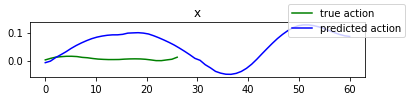

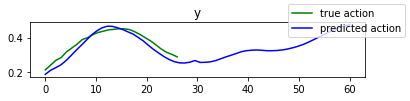

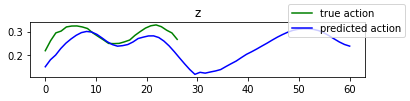

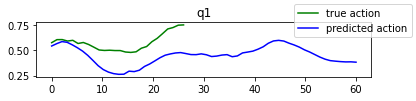

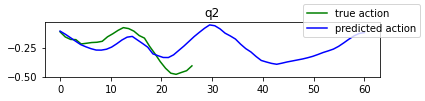

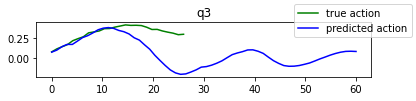

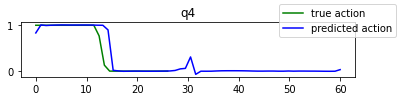

In [71]:
length_true = len(true)
length_pred = len(pred)
actions_space = true.shape[-1]
x_true = np.linspace(0, length_true, num=length_true) 
x_pred = np.linspace(0, length_pred, num=length_pred) 
if JOINTS:
    labels = ['j1', 'j2', 'j3', 'j4', 'j5', 'j6', 'j7', 'gripper']
else:
    labels = ['x','y','z','q1','q2','q3','q4','gripper']
for i in range(0,actions_space):
    fig, axes = plt.subplots(1, 1, figsize=(6,1.0), squeeze=False)
    # One Model
    axes[0,0].plot(x_true,true[:,i],'green')
    axes[0,0].plot(x_pred,pred[:,i], 'b')
    fig.legend( ('true action', 'predicted action'))
   
    plt.title(labels[i])
    plt.show()

In [105]:
state_evolve = np.squeeze(np.array(states))

In [106]:
sns.heatmap(state_evolve.T)

ValueError: Must pass 2-d input

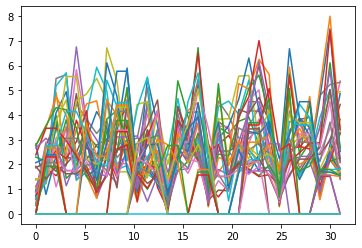

In [107]:
plt.plot(np.linspace(0,len(states)-1,len(states)-1),np.linalg.norm(state_evolve[1:,:] - state_evolve[:-1,:], axis=-1))

In [28]:

for i in range(0,20):
    data = v_it.next()
    idx = np.random.choice(BATCH_SIZE_PER_REPLICA)
    true, pred, _ = test_subsequences(data, idx, retries = 1, replay=True)
    #true, pred, states = test_subsequences(data, idx, retries = 1, replay=False)

7 3085
73085
data_collection/collected_data/new_ori_one_obj/states_and_ims/7/env_states/3085.bullet
7 3008
73008
data_collection/collected_data/new_ori_one_obj/states_and_ims/7/env_states/3008.bullet
7 3034
73034
data_collection/collected_data/new_ori_one_obj/states_and_ims/7/env_states/3034.bullet
7 3169
73169
data_collection/collected_data/new_ori_one_obj/states_and_ims/7/env_states/3169.bullet
7 2984
72984
data_collection/collected_data/new_ori_one_obj/states_and_ims/7/env_states/2984.bullet
7 2969
72969
data_collection/collected_data/new_ori_one_obj/states_and_ims/7/env_states/2969.bullet
7 3250
73250
data_collection/collected_data/new_ori_one_obj/states_and_ims/7/env_states/3250.bullet
7 3272
73272
data_collection/collected_data/new_ori_one_obj/states_and_ims/7/env_states/3272.bullet
7 3267
73267
data_collection/collected_data/new_ori_one_obj/states_and_ims/7/env_states/3267.bullet
7 3206
73206
data_collection/collected_data/new_ori_one_obj/states_and_ims/7/env_states/3206.bullet


# Transition Model Experiments

In [18]:
model_params = {'layer_size':LAYER_SIZE, 'latent_dim':LATENT_DIM, 'training':False}
if PROBABILISTIC:
    actor_stateful = create_actor(**model_params, GCBC=GCBC, num_distribs=3)
else:
    actor_stateful = create_actor(**model_params, GCBC=GCBC)

In [28]:
%%time
actor_stateful.set_weights(actor.get_weights())

CPU times: user 530 ms, sys: 220 ms, total: 751 ms
Wall time: 370 ms


In [28]:
# Create a transition model, input obs, act, output obs
import tensorflow_addons as tfa

def create_transition_model(layer_size=512):
    # params #
    batch_size = None

    # Input #
    o = Input(shape=(OBS_DIM,), batch_size=batch_size, dtype=tf.float32, name='initial_obs') # has arm state
    a = Input(shape=(ACT_DIM,), batch_size=batch_size, dtype=tf.float32, name='goal_obs') # does not have arm state

    # Layers #
    x = Concatenate(axis=-1)([o,a])
    x = Masking(mask_value=0.)(x)
    x = Dense(layer_size, activation="relu", name='layer_1')(x)
    x = Dense(layer_size, activation="relu", name='layer_2')(x)
    x = Dense(layer_size, activation="relu", name='layer_3')(x)
    o_next = Dense(OBS_DIM, name='layer_4')(x)
    
    return Model([o, a], o_next)

def make_model_batch(states, acts):
    s = states[:, :-1,:]
    a = acts[:, :-1, :]
    s_next = states[:, 1:, :]
    B,T,D = s.shape
    s = tf.reshape(s, (B*T, D))
    a = tf.reshape(a, (B*T, -1))
    s_next = tf.reshape(s_next, (B*T, D))
    return s, a, s_next


model = create_transition_model()
model_optimizer = tfa.optimizers.AdamW(weight_decay=1e-5, learning_rate=1e-4)
t_it = iter(train_dataset.repeat(-1))
v_it = iter(valid_dataset.repeat(-1))


In [29]:

# Take a batch from t_it, regress next obs to obs/act


total_steps = 10000
t = 0
steps = []
t_losses = []
v_losses = []
   
    
def step(d):
    s,a, _,_,_,_,_ = [d[k] for k in d.keys()]
    s,a,s_next = make_model_batch(s,a)
    s_pred = model((s,a))
    return tf.reduce_mean(tf.keras.losses.MAE(s_next, s_pred))

def train_step():
    with tf.GradientTape() as tape:
        d = t_it.next()
        loss = step(d)
        gradients = tape.gradient(loss, model.trainable_variables)
        model_optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

def valid_step():
    d = v_it.next()
    return step(d)


while(t<total_steps):
    
    t_loss = train_step()
    v_loss = valid_step()
    if t % 500 == 0:
        t_losses.append(t_loss)
        v_losses.append(v_loss)
        steps.append(t)
        print(t, v_loss.numpy())
        
    t += 1

0 0.2616796
500 0.08140578
1000 0.080035
1500 0.07606537
2000 0.063986965
2500 0.06395352
3000 0.061576404
3500 0.06351275


KeyboardInterrupt: 

In [30]:
def plot(array):
    plt.plot(np.linspace(0,len(array),len(array)),np.linalg.norm(array, axis=-1))

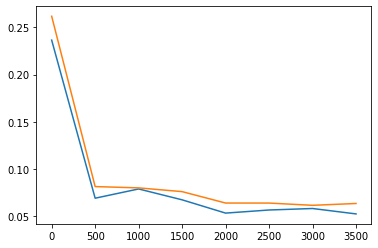

In [31]:
plt.plot(steps, t_losses)
plt.plot(steps, v_losses)

In [55]:


# Using stateful actor, play out a sequence from our trajectory bank
import time

def test_subsequences(data, idx, retries = 3, replay=False, replan_interval=20):
    
    
    states, acts, goals, seq_lens, masks, pth, tsteps = [data[k] for k in data.keys()]
    
    
    start_idx = str(int(tsteps[idx,0]))
    traj_end = len(np.where(masks[idx] == 1)[0])-1
    print(int(pth[idx,0]), int(tsteps[idx,0]))
    print(str(int(pth[idx,0]))+str(int(tsteps[idx,0])) )
    print(PYBULLET_DATA_DIR +'states_and_ims/'+str(int(pth[idx,0]))+'/env_states/'+str(int(tsteps[idx,0]))+'.bullet')

    env.p.restoreState(fileName=PYBULLET_DATA_DIR +'states_and_ims/'+str(int(pth[idx,0]))+'/env_states/'+str(int(tsteps[idx,0]))+'.bullet')
    state = env.panda.calc_state()
    if JOINTS:
        o = tf.expand_dims(tf.expand_dims(np.concatenate([state['observation'], state['joints'][:7]]),0),0)
    else:
        o = tf.expand_dims(tf.expand_dims(state['observation'],0),0)
    #print(states)
    #print(o.shape, o_p.shape, states.shape)
    #print(o, '-------------------', o_p)
    goal = goals[idx, traj_end,:]
    goal = tf.expand_dims(tf.expand_dims(goal, 0),0)
    
    if VELOCITY:
        o = tf.concat([tf.cast(o, tf.float32),tf.expand_dims(tf.expand_dims(tf.cast(state['velocity'],tf.float32),0),0)], axis = -1)
    
    if replay:
        retries = 1
    o_p = tf.expand_dims(tf.expand_dims(states[idx,0],0),0)
    a_true =  acts[idx, :traj_end]
    a_pred = []
    o_ins, a_ins = [],[]
    o_trues = []
    o_preds= []
    o_pred = tf.squeeze(o,0)
    for j in range(0,retries):
        if not GCBC:
            plan, _ = planner((o[0], goal[0]))
            z = tf.expand_dims(plan.sample(),0)
        actor.reset_states()
        if not replay:
            replan_horizon = traj_end
        else:
            replan_horizon = traj_end
            
        for i in range(0, replan_horizon):

            
            if GCBC:
                a,_,_ = actor((o, goal))
                a = a.numpy().squeeze()
                a_pred.append(a)
            else:
                a = actor((o, z,goal)).numpy().squeeze()
                a_pred.append(a)
                
            if replay or i < 0:
                a=a_true[i, :] # test whether a good init state would help by visualising the first 5 steps
            
#             o_ins.append(tf.squeeze(o,0)), a_ins.append(tf.expand_dims(a,0))
#             o_pred = model((tf.squeeze(o,0),tf.expand_dims(a,0)))
            o_ins.append(tf.squeeze(o,0)), a_ins.append(tf.expand_dims(a,0))
            o_pred = model((o_pred,tf.expand_dims(a,0)))

            env.visualise_sub_goal(np.squeeze(o_pred))
            o, r, d, _ = env.step(a)
            vel= tf.expand_dims(tf.expand_dims(tf.cast(o['velocity'],tf.float32),0),0)
            if JOINTS:
                o = tf.expand_dims(tf.expand_dims(np.concatenate([o['observation'],o['joints'][:7]]), 0),0)
            else:
                o = tf.expand_dims(tf.expand_dims(o['observation'], 0),0)
                
            if VELOCITY:
                o = tf.concat([tf.cast(o, tf.float32),vel], axis = -1)
                
            o_preds.append(o_pred.numpy())
            o_trues.append(o.numpy())
            
    return np.array(a_true), np.array(a_pred), np.squeeze(np.array(o_trues)), np.squeeze(np.array(o_preds)), np.array(o_ins), np.array(a_ins)
# Feed the actions through transition model and take a few gradient steps until it was more like what actually happened

# Take loss between model predicted state and desired state for all steps, update our actor

# rerun, if its better, then update the main model, otherwise, reset this one to main



In [59]:
env.visualise_sub_goal(np.squeeze(o_pred))
env.panda.delete_sub_goal()
env.panda.sub_goals=None

In [51]:
data = t_it.next()
idx = np.random.choice(BATCH_SIZE_PER_REPLICA)

In [60]:
true, pred, o_true, o_pred, o_in, a_in = test_subsequences(data, idx, retries = 1, replay=True)
pred_diffs = np.squeeze(abs(np.squeeze(np.array(o_true)) - np.squeeze(np.array(o_pred))))

16 4709
164709
data_collection/collected_data/one_obj_play/states_and_ims/16/env_states/4709.bullet
8
15
15
16
17
18
8
15
15
16
17
18
8
15
15
16
17
18
8
15
15
16
17
18
8
15
15
16
17
18
8
15
15
16
17
18
8
15
15
16
17
18
8
15
15
16
17
18
8
15
15
16
17
18
8
15
15
16
17
18
8
15
15
16
17
18
8
15
15
16
17
18
8
15
15
16
17
18
8
15
15
16
17
18
8
15
15
16
17
18
8
15
15
16
17
18
8
15
15
16
17
18
8
15
15
16
17
18
8
15
15
16
17
18
8
15
15
16
17
18
8
15
15
16
17
18
8
15
15
16
17
18
8
15
15
16
17
18
8
15
15
16
17
18
8
15
15
16
17
18
8
15
15
16
17
18
8
15
15
16
17
18
8
15
15
16
17
18
8
15
15
16
17
18
8
15
15
16
17
18
8
15
15
16
17
18
8
15
15
16
17
18
8
15
15
16
17
18
8
15
15
16
17
18
8
15
15
16
17
18
8
15
15
16
17
18


In [42]:
pred_diffs

array([[1.33662634e-02, 9.50123370e-03, 8.20809603e-03, 2.92086601e-03,
        2.78563425e-02, 1.86027586e-03, 7.22116232e-03, 8.85668769e-03,
        1.79850720e-02, 9.79271531e-03, 4.73928452e-03, 1.24136209e-02,
        5.39344549e-03, 1.91547275e-02, 8.27729702e-04, 9.51879844e-03,
        1.76945329e-02, 1.04417559e-02, 7.15146679e-03, 1.40375435e-01,
        1.01133101e-02, 4.39243138e-01, 6.38005733e-01, 3.39920908e-01,
        1.72276512e-01],
       [2.40480099e-02, 9.75231826e-03, 1.86058283e-02, 3.43033671e-03,
        2.56024897e-02, 1.98885500e-02, 6.10744953e-03, 8.42196867e-03,
        1.43989362e-02, 2.14907825e-02, 4.93970513e-03, 4.52691317e-03,
        1.65122747e-02, 2.27601528e-02, 4.68754768e-03, 9.96239483e-04,
        1.74840987e-02, 1.55081879e-02, 5.45195583e-03, 6.03234880e-02,
        1.52027667e-01, 5.31375110e-02, 1.43086195e+00, 1.01110697e+00,
        7.75173366e-01],
       [1.15349442e-02, 5.93468547e-04, 1.58793777e-02, 1.01437271e-02,
        1.5622

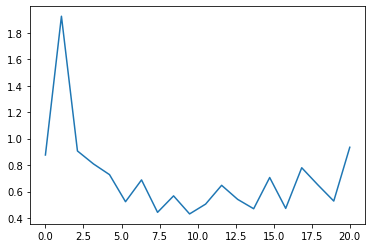

In [43]:
plot(pred_diffs)

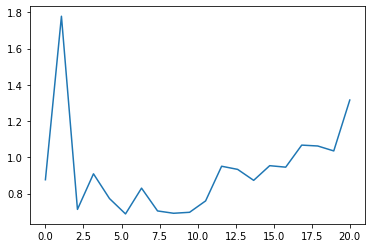

In [44]:
o = o_in[0]
simulated_o = []
for i in range(0, len(a_in)):
    o = model((o, a_in[i]))
    simulated_o.append(o)
    
pred_diffs = np.squeeze(abs(np.squeeze(np.array(o_true)) - np.squeeze(np.array(simulated_o))))
plot(pred_diffs)

In [462]:
# now, optimize the model so that it is better here
def model_update_step(o_in, a_in, o_true):
    with tf.GradientTape() as tape:
        o_pred = model((np.squeeze(o_in),np.squeeze(a_in)))
        print(o_pred.shape, o_true.shape)
        loss_time_wise = tf.keras.losses.MAE(o_pred, o_true)
        
        gradients = tape.gradient(tf.reduce_mean(loss_time_wise), model.trainable_variables)
        model_optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss_time_wise

In [472]:
np.array(simulated_o[:-1]).shape, a_in.shape, o_true.shape

((29, 1, 26), (30, 1, 8), (30, 26))

(30, 26) (30, 26)


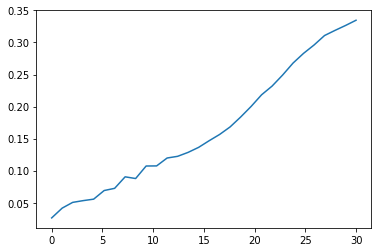

In [475]:
error = model_update_step(np.array(simulated_o),a_in, o_true)
plt.plot(np.linspace(0,len(error),len(error)),error)

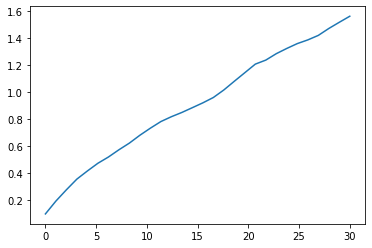

In [476]:
o = o_in[0]
simulated_o = []
for i in range(0, len(a_in)):
    o = model((o, a_in[i]))
    simulated_o.append(o)
    
pred_diffs = np.squeeze(abs(np.squeeze(np.array(o_true)) - np.squeeze(np.array(simulated_o))))
plot(pred_diffs)def create_transition_model(layer_size=512):
    # params #
    batch_size = None

    # Input #
    o = Input(shape=(OBS_DIM,), batch_size=batch_size, dtype=tf.float32, name='initial_obs') # has arm state
    a = Input(shape=(ACT_DIM,), batch_size=batch_size, dtype=tf.float32, name='goal_obs') # does not have arm state

    # Layers #
    x = Concatenate(axis=-1)([o,a])
    x = Masking(mask_value=0.)(x)
    x = Dense(layer_size, activation="relu", name='layer_1')(x)
    x = Dense(layer_size, activation="relu", name='layer_2')(x)
    x = Dense(layer_size, activation="relu", name='layer_3')(x)
    o_next = Dense(OBS_DIM, name='layer_4')(x)
    
    return Model([o, a], o_next)

In [ ]:

def quat_sign_flip(a):
    for i in range(1,len(a)):
        quat = a[i,3:7]
        last_quat = a[i-1,3:7]
        if (np.sign(quat)== -np.sign(last_quat)).all(): # i.e, it is an equivalent quaternion
             a[i,3:7] = - a[i,3:7]
    return a 


# Q Value function tests

In [ ]:
def create_q_function(layer_size=512):
    # params #
    batch_size = None

    # Input #
    o = Input(shape=(OBS_DIM,), batch_size=batch_size, dtype=tf.float32, name='initial_obs') # has arm state
    a = Input(shape=(ACT_DIM,), batch_size=batch_size, dtype=tf.float32, name='goal_obs') # does not have arm state

    # Layers #
    x = Concatenate(axis=-1)([o,a])
    x = Masking(mask_value=0.)(x)
    x = Dense(layer_size, activation="relu", name='layer_1')(x)
    x = Dense(layer_size, activation="relu", name='layer_2')(x)
    x = Dense(layer_size, activation="relu", name='layer_3')(x)
    o_next = Dense(OBS_DIM, name='layer_4')(x)
    
    return Model([o, a], o_next)


In [ ]:
# If we do it with a value function
# Discount rewards back through it - maybe using the parallelism guys thing
# then directly use AWR

# If we do it with Q... harder due to LSTM?

# Q values from (s_D, a_D, g_D)
# R from r
# Q' from nn which predicts Pi' from all s 1:,
# 

In [391]:
error

<tf.Tensor: shape=(21,), dtype=float64, numpy=
array([0.12393562, 0.01049713, 0.01037328, 0.01053249, 0.01017937,
       0.00907761, 0.00964357, 0.00983047, 0.00876082, 0.00849668,
       0.00855127, 0.00843039, 0.0092276 , 0.00918092, 0.009084  ,
       0.00929162, 0.01172736, 0.0116516 , 0.01150378, 0.00865179,
       0.00925565])>

In [16]:

import pybullet as p

def create_rpy(acts, idx):
    a = acts[idx, :int(seq_lens[idx])]
    rpys = []
    for i in range(len(a)):
        rpys.append(p.getEulerFromQuaternion(a[i,3:7]))
    xyz = a[:,0:3]
    rpy = np.array(rpys)
    g = np.expand_dims(a[:,-1],1)
    
    return np.concatenate([xyz, rpy, g], -1)
def quat_sign_flip(acts, idx):
    a = acts[idx, :int(seq_lens[idx])]
    angles = [a[0,3:7]]
    for i in range(1,len(a)):
        quat = a[i,3:7]
        last_quat = angles[-1] 
        if (np.sign(quat)== -np.sign(last_quat)).all(): # i.e, it is an equivalent quaternion
            angles.append(-quat)
        else:
            angles.append(quat)
        #print(np.sign(quat), np.sign(last_quat), (np.sign(quat)== -np.sign(last_quat)).all())
    
    #print(xyz.shape, q.shape, g.shape,q)
    return np.concatenate([xyz, q, g], -1)


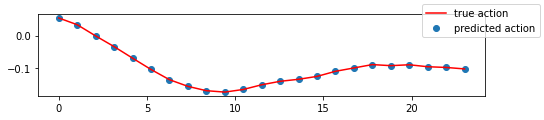

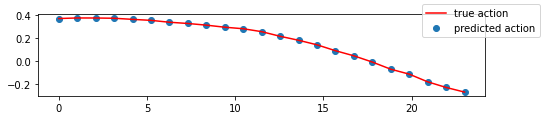

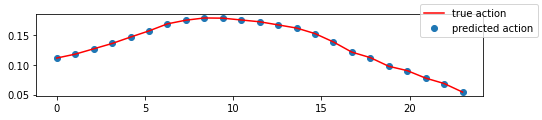

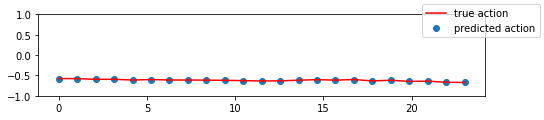

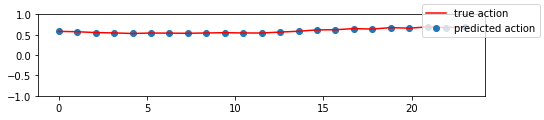

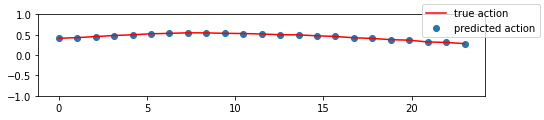

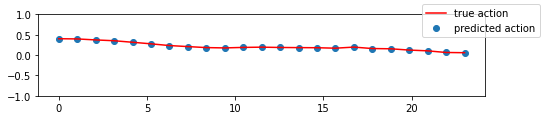

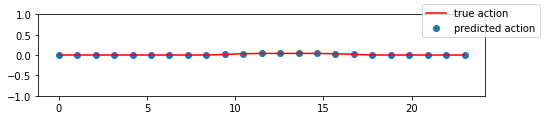

In [19]:

#@title Plot timeseries of state/action tracking over time - xyz q1234 gripper
idx = 15

length = int(seq_lens[idx])
actions_space = acts.shape[2]
x = np.linspace(0, length, num=length) 
for i in range(0,8):
    fig, axes = plt.subplots(1, 1, figsize=(8,1.5), squeeze=False)
    # One Model
    if i >= 3and i < 8:
        axes[0,0].set_ylim([-1,1])
    true = axes[0,0].plot(x,quat_sign_flip(acts,idx)[:,i],'r')
    #predicted = axes[0,0].plot(x,pred_acts[idx, :int(seq_lens[idx]),i], 'b')
    #enc_predicted = axes[0,0].plot(x,enc_act_distrib[idx, :int(seq_lens[idx]),i], 'g')
    true = axes[0,0].scatter(x,quat_sign_flip(acts,idx)[:,i])
    
    fig.legend( ('true action', 'predicted action', 'encoder_action'))
    
    
    plt.show()

In [ ]:
descriptions = {
    1: 'lift up',
    2: 'take down',
    3: 'door left',
    4: 'door right',
    5: 'drawer in',
    6: 'drawer out',
    7: 'pick place',
    8: 'press button',
    9: 'dial on',
    10: 'dial off',
    11: 'rotate block left',
    12: 'rotate block right',
    13: 'stand up block',
    14: 'knock down block',
    15: 'block in cupboard right',
    16: 'block in cupboard left',
    17: 'block in drawer',
    18: 'block out of drawer',
    19: 'block out of cupboard right',
    20: 'block out of cupboard left'
}